# Edureka - PGP -AIML - Industry Grade Project - Capstone Project - III

### Aim of the Project :

#### To build a Machine Learning Model to predict whether an owner will initiate an Auto Insurance claim next year.

#### Motivation:

    1. Conquring Market Share.
    2. Risk Management - Thru ensuring right premium.
    3. Smoothening Process - By reducing complexity of the pricing model.
    4. Increasing Profit. 

### Loading the required libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip '/content/gdrive/MyDrive/Edureka Industry Grade Project/Auto Insurance.zip'

Archive:  /content/gdrive/MyDrive/Edureka Industry Grade Project/Auto Insurance.zip
  inflating: train(1).csv            


In [3]:
import numpy as np
import pandas as pd
import copy
import os
import seaborn as sns
import matplotlib.pyplot as plt


### Loading the Dataset

In [4]:
df_data=pd.read_csv('/content/train(1).csv')

In [5]:
print(df_data.shape)
df_data.head()

(595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [6]:
df_data.id.unique().shape # id shape is same is the original length of the dataframe - can be dropped.

(595212,)

In [7]:
df_data.target.value_counts(normalize=True)

0    0.963552
1    0.036448
Name: target, dtype: float64

## Inference -1

    1. The data is having 595212 samples and 57 features, excluding id and target columns
    2. The data is highly imbalanced dataset, with only 3.6% data for class 1, which this project need to be predict correctly - which are customers who will come back for claim next year.
    3. The data contains only numeric values, with missing values identified with -1.
    4. The feature name suggest that there are categorical, binary and continous data, which need to be seggregated and understood.
    5. There are 4 groups ind,cat,car and calc.

### Segregating Binary, Categorical and Continuous feature names

In [8]:
# List of column name 
col=df_data.columns.tolist()[2:]

In [9]:
def segg_cols(col):
    bin_cols=[col_nm for col_nm in [col_nm for col_nm in col if len(col_nm.split("_"))>3] if (col_nm.split("_")[3]=='bin')]
    cat_cols=[col_nm for col_nm in [col_nm for col_nm in col if len(col_nm.split("_"))>3] if (col_nm.split("_")[3]=='cat')]
    con_cols=[col_nm for col_nm in col if len(col_nm.split("_"))<4]
    con_cols_flt= [col for col in con_cols if (df_data[col].dtypes==np.float and col != 'target')]
    con_cols_int= [col for col in con_cols if (df_data[col].dtypes=='int64' and col != 'target')]
    return bin_cols,cat_cols,con_cols_flt,con_cols_int

In [10]:
bin_cols,cat_cols,con_cols_flt,con_cols_int=segg_cols(col)

In [11]:
print("Features having Binary Values : ", bin_cols[0:3], " Length : ", len(bin_cols) ,'\n')
print('-'*120)
print("Features having Categorical Values : ", cat_cols[0:3]," Length : ", len(cat_cols) ,'\n')
print('-'*120)
print("Features having Continuous Values - Float : ", con_cols_flt[0:4]," Length : ", len(con_cols_flt) ,'\n')
print('-'*120)
print("Features having Continuous Values Integer : ", con_cols_int[0:4]," Length : ", len(con_cols_int) ,'\n')

Features having Binary Values :  ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin']  Length :  17 

------------------------------------------------------------------------------------------------------------------------
Features having Categorical Values :  ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']  Length :  14 

------------------------------------------------------------------------------------------------------------------------
Features having Continuous Values - Float :  ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12']  Length :  10 

------------------------------------------------------------------------------------------------------------------------
Features having Continuous Values Integer :  ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15']  Length :  16 



## Categorical Features

In [12]:
df_data[cat_cols].describe()

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.358943,0.416794,0.405188,8.295933,0.829948,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674
std,0.664594,0.493311,1.350642,2.508270,0.375679,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455
min,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000
25%,1.000000,0.000000,0.000000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000
50%,1.000000,0.000000,0.000000,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000
75%,2.000000,1.000000,0.000000,11.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.000000,1.000000,2.000000,1.000000,93.000000
max,4.000000,1.000000,6.000000,11.000000,1.000000,1.000000,9.000000,1.000000,17.000000,1.000000,1.000000,4.000000,2.000000,104.000000


In [13]:
df_data.ps_car_11_cat.value_counts().index.shape

(104,)

### Inference - Categorical Features
    1. Total 14 Categorical Features
    2. ps_car_11_cat - There are 104 categories captured in a column, which is the highest for any column in this category. 
    3. Categorical features includes some binary features such as ps_ind_04_cat,ps_car_02_cat,ps_car_03_cat,ps_car_05_cat,ps_car_07_cat,ps_car_08_cat
    4. This category contain unfilled values - which need to be cleaned
    5. Only contain 'ind' and 'car' groups in this category

## Binary Features

In [14]:
df_data[bin_cols].describe()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Inference - Binary Features

    1. Total 17 Features
    2. Binary data donot have any missing values
    3. Only contain 'ind' and 'calc' groups in this category
    

## Continuous Features - Interval and Ratio Variables

In [15]:
df_data[con_cols_flt].head()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
0,0.7,0.2,0.718070,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2
1,0.8,0.4,0.766078,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3
2,0.0,0.0,-1.000000,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1
3,0.9,0.2,0.580948,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1
4,0.7,0.6,0.840759,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0


In [16]:
df_data[con_cols_flt].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [17]:
print(df_data.ps_calc_01.value_counts().index)
print(df_data.ps_calc_02.value_counts().index)
print(df_data.ps_calc_03.value_counts().index)
print(df_data.ps_reg_01.value_counts().index)
print(df_data.ps_reg_02.value_counts().index)

Float64Index([0.6, 0.0, 0.8, 0.5, 0.7, 0.2, 0.1, 0.3, 0.4, 0.9], dtype='float64')
Float64Index([0.5, 0.4, 0.0, 0.3, 0.7, 0.6, 0.2, 0.1, 0.9, 0.8], dtype='float64')
Float64Index([0.1, 0.5, 0.3, 0.6, 0.8, 0.9, 0.7, 0.0, 0.4, 0.2], dtype='float64')
Float64Index([0.9, 0.7, 0.8, 0.6, 0.4, 0.1, 0.3, 0.5, 0.2, 0.0], dtype='float64')
Float64Index([0.2, 0.3, 0.0, 0.4, 0.5, 0.6, 0.1, 0.7, 0.8, 0.9, 1.2, 1.0, 1.3,
              1.1, 1.4, 1.5, 1.6, 1.8, 1.7],
             dtype='float64')


In [18]:
# Creating column list for ratio and interval columns
def ext_inter_ratio(con_cols_flt):
    con_cols_flt_interval=['ps_calc_01','ps_calc_02','ps_calc_03','ps_reg_01','ps_reg_02']#Based on data structure visualized at df.head
    con_cols_flt_ratio=[col for col in con_cols_flt if col not in con_cols_flt_interval]
    return con_cols_flt_interval,con_cols_flt_ratio

In [19]:
con_cols_flt_interval,con_cols_flt_ratio=ext_inter_ratio(con_cols_flt)

In [20]:
con_cols_flt_ratio

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']

(array([1.11291812, 1.10853126, 1.1085686 , 1.11245144, 1.11674496,
        1.12135583, 1.11073403, 1.1107527 , 1.10358438, 1.1054698 ]),
 array([0.  , 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.9 ]),
 <a list of 1 Patch objects>)

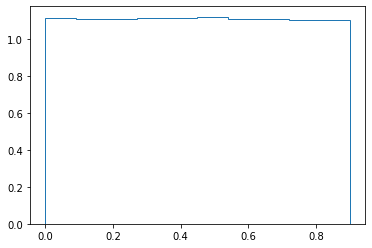

In [21]:
plt.hist(x = df_data['ps_calc_02'],density=True,histtype = 'step')


### Inference 

### Continuous Features - Interval Variables

    1. Total 10 Features
    2. From the above description of the data, it looks that ps_calc_01,ps_calc_02,ps_calc_03 have uniform distribution, 
    since its upper and lower quartile and the median are same.Moreover these variables are not random ratio variables, can be classified into intervals - These variable are in order, yet float values
    3. Features ps_reg_01 and ps_reg_02 also classified into intervals.
    4. No unfilled values
    
### Continuous Features - Ratio Variables

    1. There are 4 fetures, which looks form the features to contain ratio variables.
    2. Contains missing values in features having ratio variables. (3 out of 5 Features)
   

## Continuous Features - Ordinal Variables

In [22]:
df_data[con_cols_int].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


### Inference - Continuous Features - Ordinal Variables

    1. Total 16 featues
    2. Only 1 feature is having missing value.
    3. Highest ordinal value reported in feature - ps_calc_14 - is 23.
    4. Lowest ordinal value reported in feature - ps_car_11 - is 03.

In [23]:
## Columns having 

In [24]:
df_unfill=df_data[df_data==-1].count().reset_index(name='unfill_nos').set_index('index')
print("Total no. of columns having unfilled values : ",df_unfill[df_unfill.unfill_nos.values>0].shape[0] )
df_unfill[df_unfill.unfill_nos.values>0]

Total no. of columns having unfilled values :  12


,unfill_nos
index,
ps_ind_02_cat,216
ps_ind_04_cat,83
ps_ind_05_cat,5809
ps_reg_03,107772
ps_car_01_cat,107
ps_car_03_cat,411231
ps_car_05_cat,266551
ps_car_07_cat,11489
ps_car_09_cat,569


## Seggregation of Columns having unfilled data

In [25]:
# Function captures the characteristics of the columns having unfilled data with respect to target columns
def update_dict(dict_final,df,col_lst):
    
    for col in col_lst:
        idx_lst = df[col][df[col]==-1].index.tolist()
        if(df.loc[idx_lst].target.value_counts().shape[0]>1): # for columns having indexes for 2 class
            num_tar_0=df.loc[idx_lst].target.value_counts()[0] #for a column count of unfilled index - with class 0
            num_tar_1=df.loc[idx_lst].target.value_counts()[1] #for a column count of unfilled index - with class 1            
            # Percentage of class contribution of the index with respect to the actual class content in the target column
            pct_tar_0=np.round((df.loc[idx_lst].target.value_counts()[0]/df.target.value_counts()[0])*100,2)
            pct_tar_1=np.round((df.loc[idx_lst].target.value_counts()[1]/df.target.value_counts()[1])*100,2)
        else:
            num_tar_0=df.loc[idx_lst].target.value_counts()[0] # for columns having indexes for 1 class
            num_tar_1=0         
            pct_tar_0=np.round((df.loc[idx_lst].target.value_counts()[0]/df.target.value_counts()[0])*100,2)
            pct_tar_1=np.round(0,2)
       
        dict_final[col]['num_tar_0']=num_tar_0
        dict_final[col]['num_tar_1']=num_tar_1
        dict_final[col]['pct_tar_0']=pct_tar_0
        dict_final[col]['pct_tar_1']=pct_tar_1
        dict_final[col]['Dtype']=df[col].dtypes #capturing the data type of the column
        dict_final[col]['idx_lst']=idx_lst # the indexes of the column having unfilled values
        
    return dict_final

In [26]:
def df_status(df):
    col= df.columns
    lst=df[df[col]==-1].any().reset_index().values.tolist()
    column_not_filled=[pair[0] for pair in lst if pair[1]==True]
    #Calculating total unfilled count and % of unfilled count with respect to the total number of observations
    col_wise_unfilled_vals={colm:{'n_fill_cnt':df[df[colm].values==-1].index.shape[0],'pct':np.round((df[df[colm].values==-1].index.shape[0]/df.shape[0])*100,3) } for colm in column_not_filled}
    dict_1=update_dict(col_wise_unfilled_vals,df,column_not_filled)
    df_updt=pd.DataFrame(dict_1).transpose()
    return df_updt

In [27]:
# Extracting the columns having unfilled values along with parameters 
df_temp=df_status(df_data)

In [28]:
# Dataframe capturing the columns having missing values, along with other parameters
print(df_temp.shape)
df_temp

(12, 8)


,n_fill_cnt,pct,num_tar_0,num_tar_1,pct_tar_0,pct_tar_1,Dtype,idx_lst
ps_ind_02_cat,216,0.036,176,40,0.03,0.18,int64,"[847, 11840, 13670, 13804, 14002, 14089, 18909..."
ps_ind_04_cat,83,0.014,50,33,0.01,0.15,int64,"[847, 12329, 13670, 13804, 23056, 39143, 39820..."
ps_ind_05_cat,5809,0.976,5325,484,0.93,2.23,int64,"[152, 188, 218, 249, 609, 659, 721, 778, 847, ..."
ps_reg_03,107772,18.106,104712,3060,18.26,14.11,float64,"[2, 15, 18, 23, 25, 28, 47, 55, 60, 66, 70, 73..."
ps_car_01_cat,107,0.018,73,34,0.01,0.16,int64,"[847, 13670, 13804, 23056, 39143, 39820, 43129..."
ps_car_03_cat,411231,69.09,397781,13450,69.36,62,int64,"[0, 1, 2, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, ..."
ps_car_05_cat,266551,44.783,258099,8452,45,38.96,int64,"[1, 2, 4, 10, 11, 12, 14, 16, 18, 19, 20, 21, ..."
ps_car_07_cat,11489,1.93,10591,898,1.85,4.14,int64,"[95, 152, 188, 218, 223, 225, 249, 411, 492, 5..."
ps_car_09_cat,569,0.096,517,52,0.09,0.24,int64,"[56, 146, 847, 972, 1029, 2009, 3141, 3883, 48..."
ps_car_11,5,0.001,5,0,0,0,int64,"[133828, 142554, 227030, 474546, 533634]"


### Inference

    1. Total 12 Columns are having unfilled values

#### Categorical

    1. ps_car_03_cat - 69% - Unfilled Data - It is categorical data - avg. not possible - 62% contribution to target 1
        Action - To be removed
    2. ps_car_05_cat - 45%  - Unfilled Data - It is categorical data - avg. not possible - 39% Contribution to target 1 
        Action - To be removed.
   
    3. ps_ind_02_cat - 0.036% - Unfilled Data - 0.18% Contribution to Target 1 
        Action - corresponsing rows can be removed
    4. ps_ind_04_cat - 0.014% - Unfilled Data - 0.15% Contribution to Target 1
        Action - corresponding rows can be removed
    5. ps_ind_05_cat - 0.976% - Unfilled Data - 2.23% Contribution to Target 1 
        Action - further investigation required.
    6. ps_car_01_cat - 0.018% - Unfilled Data - 0.16% Contribution to Target 1
        Action - corresponsing rows can be removed
    7. ps_car_07_cat - 1.93% - Unfilled Data - 4.14% Contribution to Target 1
        Action - further investigation required.
    8. ps_car_08_cat - 0.096% - Unfilled Data - 0.24% Contribution to Target 1
        Action - corresponding rows can be removed.
        
#### Float
    9. ps_reg_03 - 18.11% - Unfilled Data - 14.11% Contribution to Target 1
        Action - median values may be filled - further investigation required.
    10.ps_car_12 - 0.0% - Unfilled Data - 0.0% Contribution to Target 1 - 1 observation
        Action - corresponding rows may be removed
    11. ps_car_14 - 7.16% - Unfilled Data - 7.94% Contribution to Target 1 - 1 observation
        Action - median values need to be filled - futher investigation required

#### Ordinal
    12. ps_car_11 - 0.001- Unfilled Data - 0.0% Contribution to Target 1 - 5 observations
        Action - max freq ordinal no. can be used.

In [29]:
# Taking a copy of the original dataframe 
df_data_am_1=copy.deepcopy(df_data)

In [30]:
# Dropping the column having highest no. of unfilled data and also the column with id
df_data_am_1.drop(['id','ps_car_03_cat','ps_car_05_cat'],axis=1,inplace=True)

In [31]:
# After removal of 2 columns - checking the status of the dataframe with unfilled values
df_updt_1=df_status(df_data_am_1)

In [32]:
df_updt_1

,n_fill_cnt,pct,num_tar_0,num_tar_1,pct_tar_0,pct_tar_1,Dtype,idx_lst
ps_ind_02_cat,216,0.036,176,40,0.03,0.18,int64,"[847, 11840, 13670, 13804, 14002, 14089, 18909..."
ps_ind_04_cat,83,0.014,50,33,0.01,0.15,int64,"[847, 12329, 13670, 13804, 23056, 39143, 39820..."
ps_ind_05_cat,5809,0.976,5325,484,0.93,2.23,int64,"[152, 188, 218, 249, 609, 659, 721, 778, 847, ..."
ps_reg_03,107772,18.106,104712,3060,18.26,14.11,float64,"[2, 15, 18, 23, 25, 28, 47, 55, 60, 66, 70, 73..."
ps_car_01_cat,107,0.018,73,34,0.01,0.16,int64,"[847, 13670, 13804, 23056, 39143, 39820, 43129..."
ps_car_07_cat,11489,1.93,10591,898,1.85,4.14,int64,"[95, 152, 188, 218, 223, 225, 249, 411, 492, 5..."
ps_car_09_cat,569,0.096,517,52,0.09,0.24,int64,"[56, 146, 847, 972, 1029, 2009, 3141, 3883, 48..."
ps_car_11,5,0.001,5,0,0,0,int64,"[133828, 142554, 227030, 474546, 533634]"
ps_car_12,1,0,1,0,0,0,float64,[298018]
ps_car_14,42620,7.16,40897,1723,7.13,7.94,float64,"[46, 64, 73, 74, 88, 102, 112, 116, 126, 131, ..."


In [33]:
# Identifying the column whose percentage contribution of unfilled values is less than 0.5% with respect to the total number of observation.
cols_lst=df_updt_1[df_updt_1.pct<0.5].index.tolist()
print(cols_lst)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_car_01_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12']


In [34]:
idx_list=df_updt_1.loc[cols_lst].idx_lst.tolist()

In [35]:
# Collecting all the indexes,which need to be removed.
idx_lst_agg=set()
_=[idx_lst_agg.update(lst) for lst in idx_list]

In [36]:
# type casting as list
idx_lst_agg=list(idx_lst_agg)

In [37]:
# Dropping the indexes 
df_data_am_1.drop(idx_lst_agg,axis=0,inplace=True)

In [38]:
# Before removal of rows
df_data.target.value_counts(normalize=True)

0    0.963552
1    0.036448
Name: target, dtype: float64

In [39]:
#After removal of rows
df_data_am_1.target.value_counts(normalize=True)

0    0.963627
1    0.036373
Name: target, dtype: float64

### Inference - Above comparison shows that the ratio of classes is maintained after removal of rows.

In [40]:
# Creating the dataframe to check the columns having unfilled values after removal of rows.
df_updt_2=df_status(df_data_am_1)

In [41]:
df_updt_2

,n_fill_cnt,pct,num_tar_0,num_tar_1,pct_tar_0,pct_tar_1,Dtype,idx_lst
ps_ind_05_cat,5708,0.96,5258,450,0.92,2.08,int64,"[152, 188, 218, 249, 609, 659, 721, 778, 898, ..."
ps_reg_03,107572,18.096,104552,3020,18.25,13.97,float64,"[2, 15, 18, 23, 25, 28, 47, 55, 60, 66, 70, 73..."
ps_car_07_cat,11282,1.898,10421,861,1.82,3.98,int64,"[95, 152, 188, 218, 223, 225, 249, 411, 492, 5..."
ps_car_14,42554,7.159,40838,1716,7.13,7.94,float64,"[46, 64, 73, 74, 88, 102, 112, 116, 126, 131, ..."


In [42]:
df_data_am_1[df_updt_2.index.tolist()].describe()

,ps_ind_05_cat,ps_reg_03,ps_car_07_cat,ps_car_14
count,594449.000000,594449.000000,594449.000000,594449.000000
mean,0.405545,0.551229,0.910675,0.276289
std,1.350840,0.793307,0.345404,0.357111
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.525000,1.000000,0.333916
50%,0.000000,0.720677,1.000000,0.368782
75%,0.000000,1.000000,1.000000,0.396485
max,6.000000,4.037945,1.000000,0.636396


In [43]:
# Checking the values of the column - ps_car_07_cat
# It is having only 1,0 and -1 as values
# here, we can distribute the unfilled values as per the existing proportion of 1 and 0
df_data_am_1.ps_car_07_cat.value_counts()

 1    552632
 0     30535
-1     11282
Name: ps_car_07_cat, dtype: int64

In [44]:
# Calculation the proportion of 0 with respect to 1's
ps_car_07_cat_ratio=np.ceil((df_data_am_1.ps_car_07_cat.value_counts()[0]/df_data_am_1.ps_car_07_cat.value_counts()[1])*100)
ps_car_07_cat_ratio

6.0

In [45]:
# Capturing the total no of unfilled values in the feature ps_car_07_cat and taking 6% of the indexes
# So as to keep the distribution of 0 and 1 same
idx_lim_0=int(np.ceil(df_updt_2.loc['ps_car_07_cat'].n_fill_cnt*6/100))


In [46]:
# As per the percentage seggregating the indexes
ps_car_07_cat_0_fill_idx=df_updt_2.loc['ps_car_07_cat'].idx_lst[0:idx_lim_0] # 6% of the len of index
ps_car_07_cat_1_fill_idx=df_updt_2.loc['ps_car_07_cat'].idx_lst[idx_lim_0:] # rest

In [47]:
# Feeding the valus to the index position determined above
df_data_am_1.ps_car_07_cat.loc[ps_car_07_cat_0_fill_idx]=0
df_data_am_1.ps_car_07_cat.loc[ps_car_07_cat_1_fill_idx]=1


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [48]:
df_updt_3=df_status(df_data_am_1)

In [49]:
df_updt_3

,n_fill_cnt,pct,num_tar_0,num_tar_1,pct_tar_0,pct_tar_1,Dtype,idx_lst
ps_ind_05_cat,5708,0.96,5258,450,0.92,2.08,int64,"[152, 188, 218, 249, 609, 659, 721, 778, 898, ..."
ps_reg_03,107572,18.096,104552,3020,18.25,13.97,float64,"[2, 15, 18, 23, 25, 28, 47, 55, 60, 66, 70, 73..."
ps_car_14,42554,7.159,40838,1716,7.13,7.94,float64,"[46, 64, 73, 74, 88, 102, 112, 116, 126, 131, ..."


In [50]:
# Investigating the feature ps_ind_05_cat
# It has multiple values hence replacing the unfilled values with most frequently occuring value, which is 0
df_data_am_1.ps_ind_05_cat.value_counts()

 0    527401
 6     20644
 4     18333
 1      8311
 3      8226
-1      5708
 2      4177
 5      1649
Name: ps_ind_05_cat, dtype: int64

In [51]:
# Most frequently occuring the value in the feature is calculated thru mode
df_data_am_1['ps_ind_05_cat'].mode()[0]

0

In [52]:
#extracting the index value from the updated dataframe and introducing the mode value in that field
df_data_am_1['ps_ind_05_cat'].loc[df_updt_3.loc['ps_ind_05_cat'].idx_lst]=df_data_am_1['ps_ind_05_cat'].mode()[0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [53]:
df_updt_4=df_status(df_data_am_1)
df_updt_4

,n_fill_cnt,pct,num_tar_0,num_tar_1,pct_tar_0,pct_tar_1,Dtype,idx_lst
ps_reg_03,107572,18.096,104552,3020,18.25,13.97,float64,"[2, 15, 18, 23, 25, 28, 47, 55, 60, 66, 70, 73..."
ps_car_14,42554,7.159,40838,1716,7.13,7.94,float64,"[46, 64, 73, 74, 88, 102, 112, 116, 126, 131, ..."


In [54]:
# Putting the nan values in all the postion, which was filled with -1 for the features ps_reg_03 and ps_car_14, 
## so that fillna can be used
df_data_am_1.ps_reg_03.loc[df_updt_4.loc['ps_reg_03'].idx_lst]=np.nan
df_data_am_1.ps_car_14.loc[df_updt_4.loc['ps_car_14'].idx_lst]=np.nan

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [55]:
# Median values are updated in the index position of the dataframe
df_data_am_1.ps_reg_03.loc[df_updt_4.loc['ps_reg_03'].idx_lst]=df_data_am_1.ps_reg_03.fillna(df_data_am_1.ps_reg_03.median())
df_data_am_1.ps_car_14.loc[df_updt_4.loc['ps_car_14'].idx_lst]=df_data_am_1.ps_car_14.fillna(df_data_am_1.ps_car_14.median())

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [56]:
df_updt_5=df_status(df_data_am_1)
df_updt_5

""


## All unfilled data has been removed.

# Storing data free of Nan values in pickle file

In [89]:
df_data_am_1.to_pickle(os.path.join(os.getcwd(),'df_no_unfill.pkl'))

# Section 2 - Exploration of data and Understanding

In [90]:
# Reading from a pickle file containing cleaned data from the unfilled values
df_data_am_2= pd.read_pickle(os.path.join(os.getcwd(),'df_no_unfill.pkl'))

In [91]:
df_data_am_2.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,0,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,0,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,0.801561,7,1,0,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,0,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [92]:
df_data_am_2.target.value_counts(normalize=True)

0    0.963627
1    0.036373
Name: target, dtype: float64

### Inference - The dataset is highly imbalanced data set, only 3.6% of the data belonging to the target class 1.

    1. To balance this data, a resampling activity to be carried out - to increase the minority class. 
    2. SMOTE will be applied on to it - only on the training dataset

In [93]:
def segg_cols_updt(col):
    bin_cols=[col_nm for col_nm in [col_nm for col_nm in col if len(col_nm.split("_"))>3] if (col_nm.split("_")[3]=='bin')]
    cat_cols=[col_nm for col_nm in [col_nm for col_nm in col if len(col_nm.split("_"))>3] if (col_nm.split("_")[3]=='cat')]
    con_cols=[col_nm for col_nm in col if len(col_nm.split("_"))<4]
    con_cols_flt= [col for col in con_cols if (df_data[col].dtypes==np.float and col != 'target')]
    con_cols_int= [col for col in con_cols if (df_data[col].dtypes=='int64' and col != 'target')]
    return bin_cols,cat_cols,con_cols_flt,con_cols_int

In [94]:
#Extracting Columns of diffrernt datatypes
bin_col,cat_cols,con_cols_flt,con_cols_int=segg_cols(df_data_am_2.columns)
con_cols_flt_interval,con_cols_flt_ratio=ext_inter_ratio(con_cols_flt)

In [95]:
bin_col.append('target')
cat_cols.append('target')
con_cols_flt_interval.append('target')
con_cols_flt_ratio.append('target')
con_cols_int.append('target')

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
def corr_show(df,cols):
    corr=df[cols].corr(method='pearson')
    f,ax=plt.subplots(figsize=(15,15))
    sns.heatmap(corr,annot=True,ax=ax)
    plt.show()

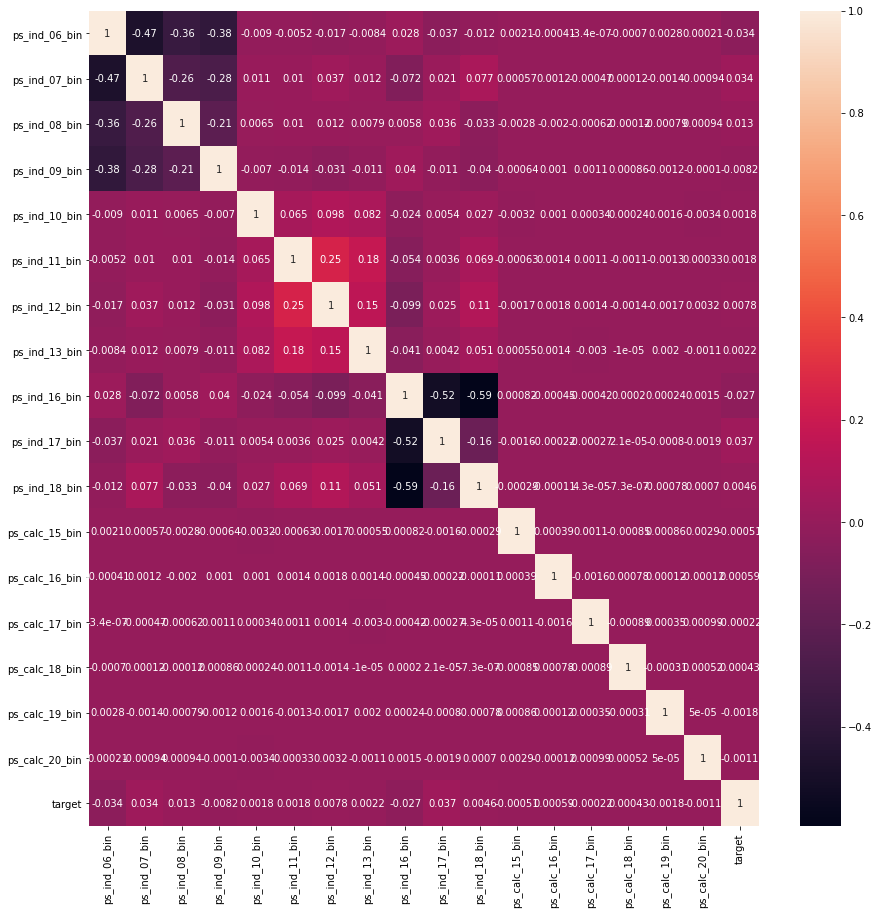

In [98]:
# Generation the Correlation matrix heat map for binary data along with target

corr_show(df_data_am_2,bin_col)


### Inference - Binary Feature Correlation
    1. ps_ind_11_bin and ps_ind_12_bin have correlation of 0.25
    2. ps_ind_11_bin and ps_ind_13_bin have correlation of 0.18
    3. ps_ind_16_bin and ps_ind_17_bin have negetive-correlation of -0.52
    4. ps_ind_16_bin and ps_ind_18_bin have negetive-correlation of -0.59
    5. ps_ind_06_bin and ps_ind_07_bin have negetive-correlation of -0.47
    6. ps_ind_06_bin and ps_ind_08_bin have negetive-correlation of -0.36
    7. ps_ind_06_bin and ps_ind_09_bin have negetive-correlation of -0.38
   

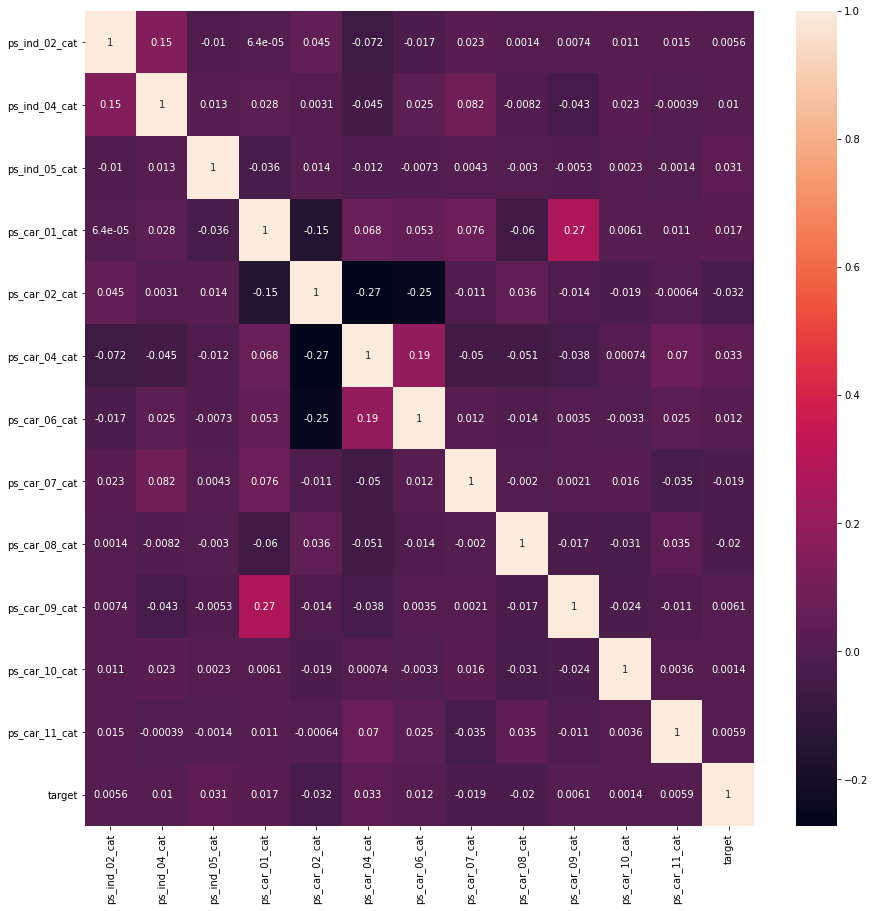

In [99]:
# Generation the Correlation matrix heat map for Catagorical features along with target

corr_show(df_data_am_2,cat_cols)


### Inference - Categorical Feature Correlation
    1. Maximum positive correlation is noted is 0.27, between ps_car_09_cat and ps_car_01_cat
    2. Maximum negetive correlation is noted is -0.27, between ps_car_04_cat and ps_car_02_cat
   

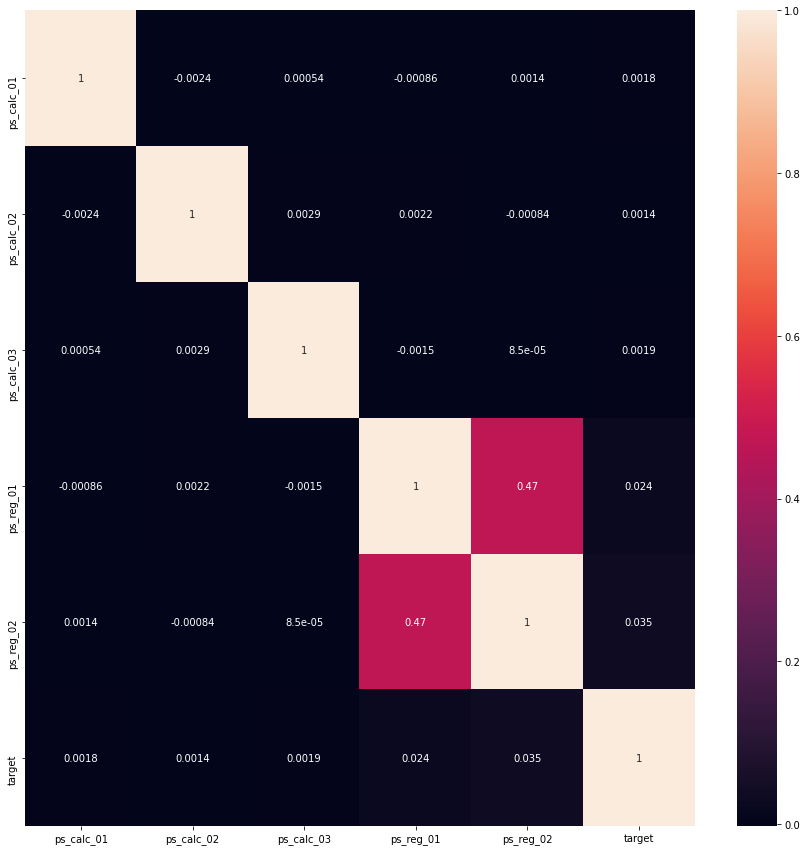

In [100]:
# Generation the Correlation matrix heat map for Continuous Float features - Interval Variables along with target

corr_show(df_data_am_2,con_cols_flt_interval)

### Inference - Continuous Feature - Interval Variables Correlation
    1. Maximum positive correlation is noted is 0.47, between ps_reg_02 and ps_reg_01
    2. Negative correlation not observed.
    3. Target not is significantly correlated with any of the features
   

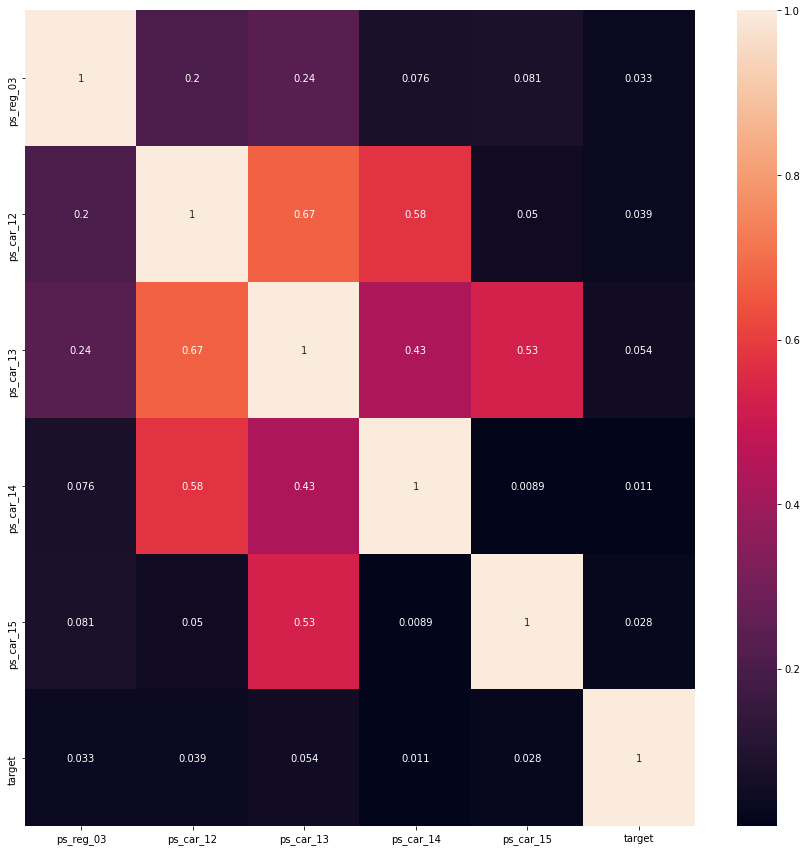

In [101]:
# Generation the Correlation matrix heat map for Continuous Float features - Ratio Variables along with target

corr_show(df_data_am_2,con_cols_flt_ratio)

### Inference - Continuous Feature - Ratio Variables Correlation
    1. Moderate positive correlation is noted is 0.67, between ps_car_12 and ps_car_13
    2. Moderate positive correlation is noted is 0.58, between ps_car_12 and ps_car_14
    3. Moderate positive correlation is noted is 0.43, between ps_car_13 and ps_car_14
    4. Moderate positive correlation is noted is 0.53, between ps_car_13 and ps_car_15
    4. Negative correlation not observed.
    5. Target not is significantly correlated with any of the features
    6. Correlation of ps_car_13 is highest with target among other features

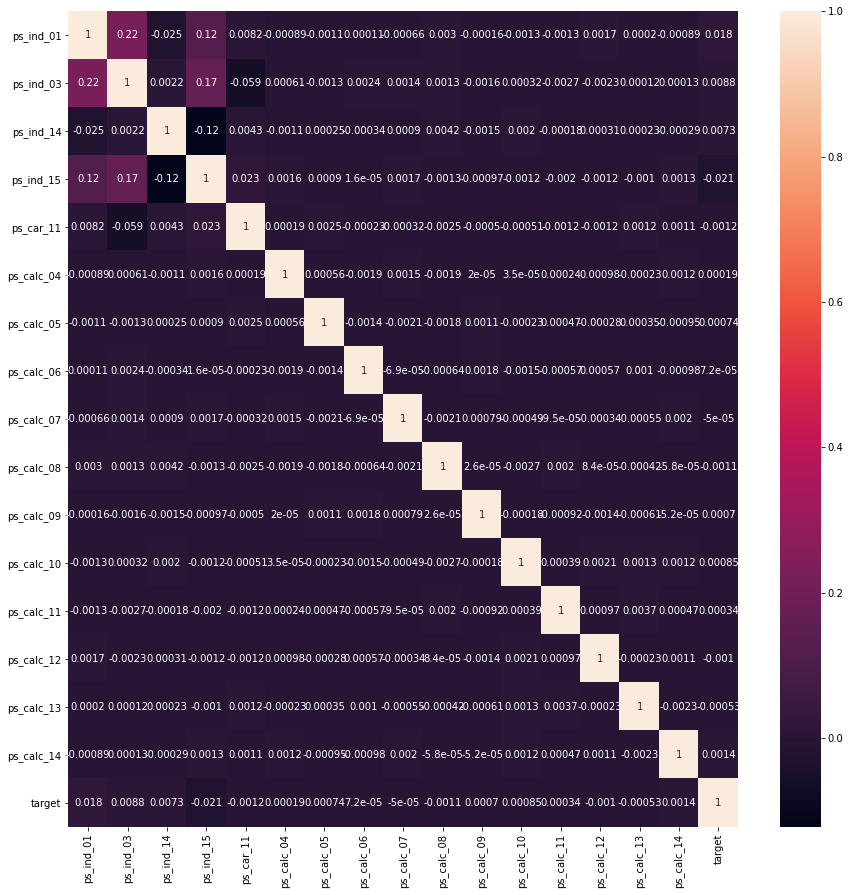

In [102]:
# Generation the Correlation matrix heat map for Continuous Integer features along with target

corr_show(df_data_am_2,con_cols_int)

### Inference - Continuous Feature - Float Correlation
    1. Low positive correlation is noted is 0.22, between ps_ind_01 and ps_ind_03
    2. Low negetive correlation is noted is -0.12, between ps_ind_14 and ps_ind_15

In [103]:
# # Dropping the target column
# if 'target' in bin_col: bin_col.pop()
# if 'target' in cat_cols: cat_cols.pop()
# if 'target' in con_cols_flt: con_cols_flt_interval.pop()
# if 'target' in con_cols_flt: con_cols_flt_ratio.pop()    
# if 'target' in con_cols_int: con_cols_int.pop()

## Univariate Visualizations

In [104]:
# Function to generate histogram for the categorical, float and integer feature.
def gen_hist(df,col):
    f,ax=plt.subplots(figsize=(15,15))
    df[col].hist(ax=ax)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


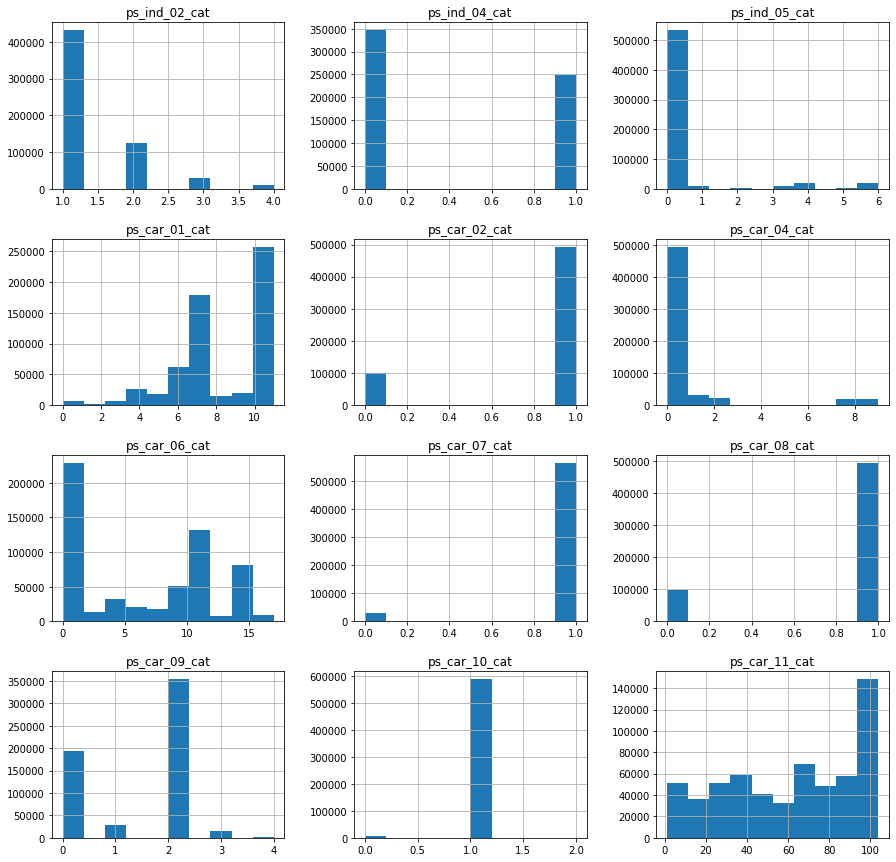

In [105]:
# Histogram for Categorical Features

gen_hist(df_data_am_2,cat_cols[0:-1])

## Inference - Categorical Variable - Univariate Visualization

    1. Distribution of categories - is not uniform featurewise. In majority of the cases, one single category is dominant.

## Bi-Variate Visualization - Categorical Variable

In [106]:
df_cat=copy.deepcopy(df_data_am_2[cat_cols])

In [107]:
from matplotlib.pyplot import figure

In [108]:
# Function to plot Bi-Variate Graphs with target
def bi_variate_viz(df):
    cols=df.columns.tolist()
    targ=cols.pop()
    n_cols=len(cols)
    p=1
    while p<n_cols+1:
        df_temp=pd.crosstab(df[cols[p-1]],df[targ])
        df_temp.plot.bar(subplots=True,figsize=(15,8))
        p+=1
        plt.show()        
    

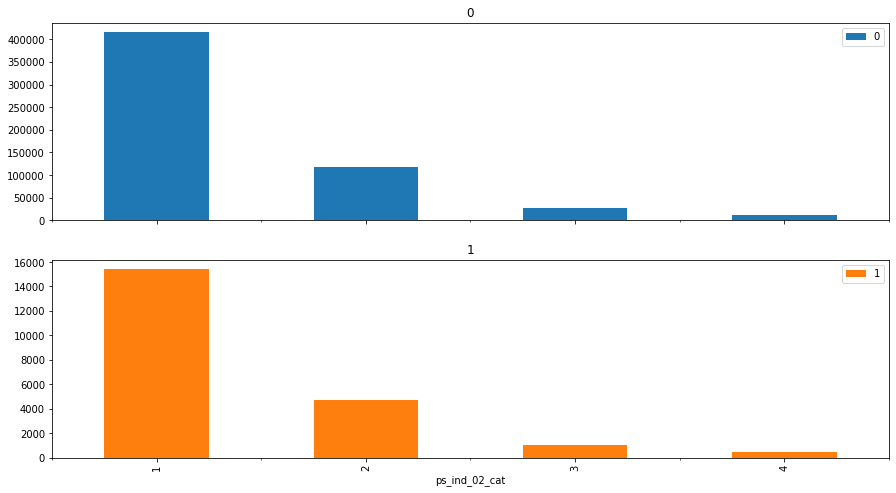

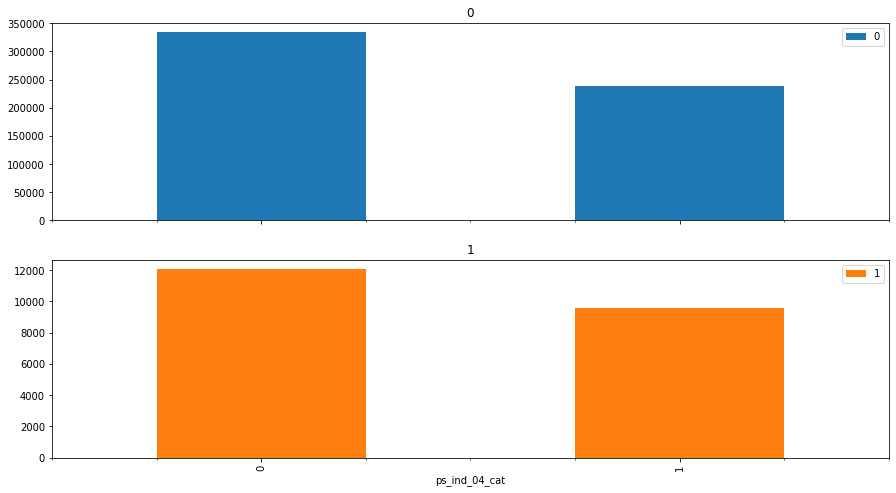

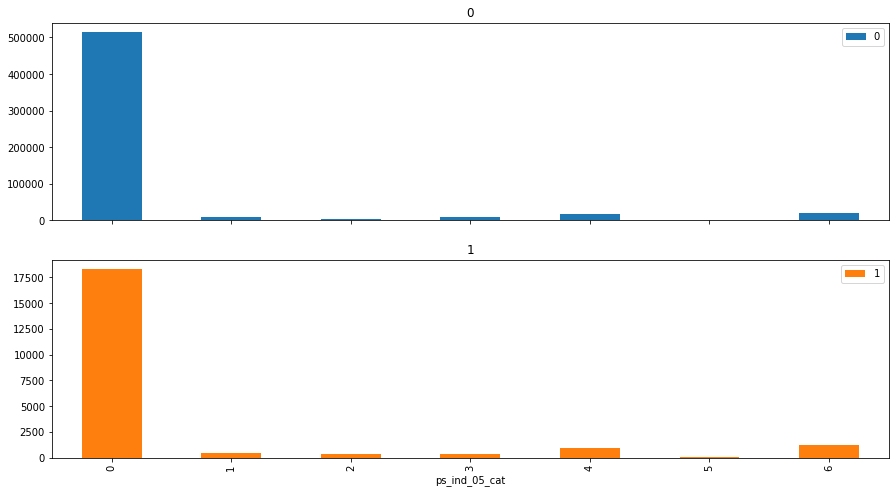

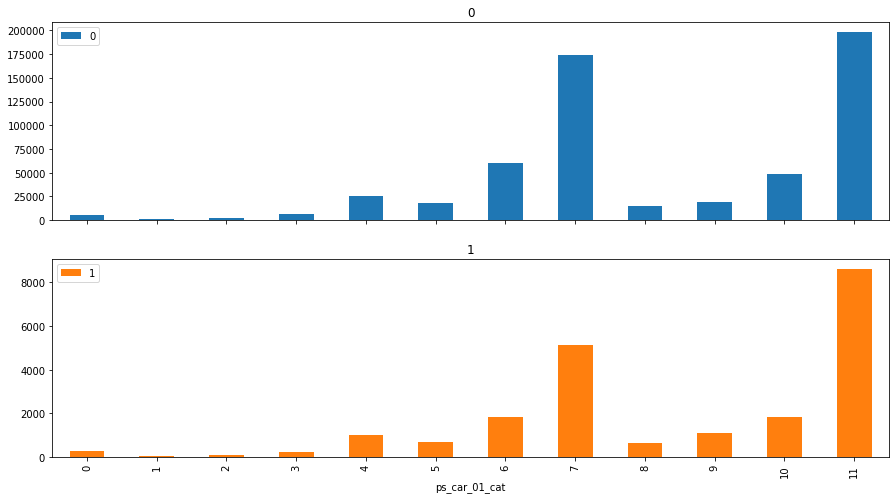

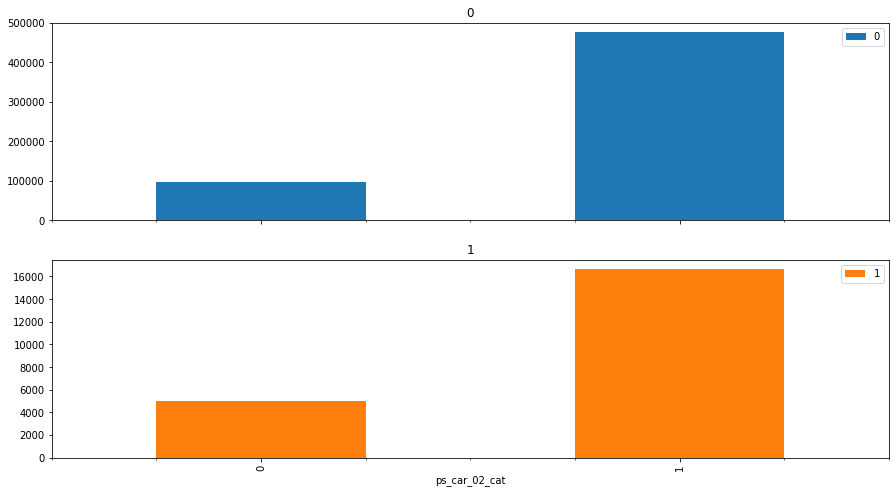

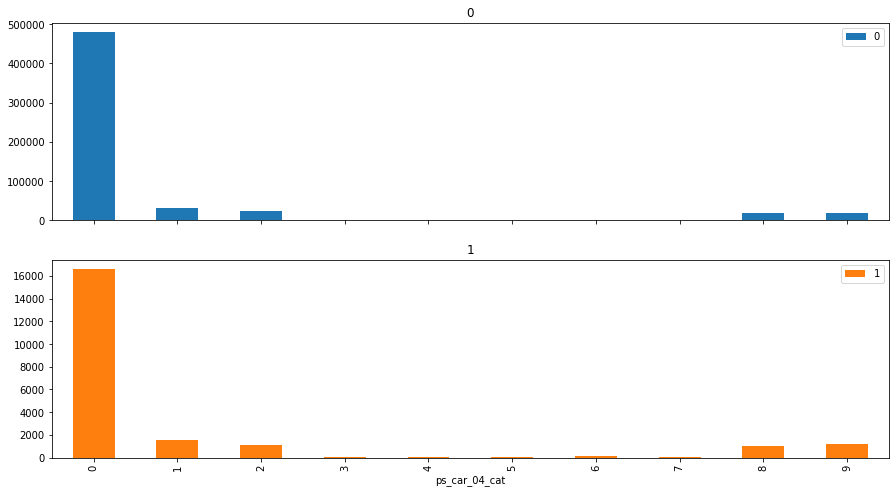

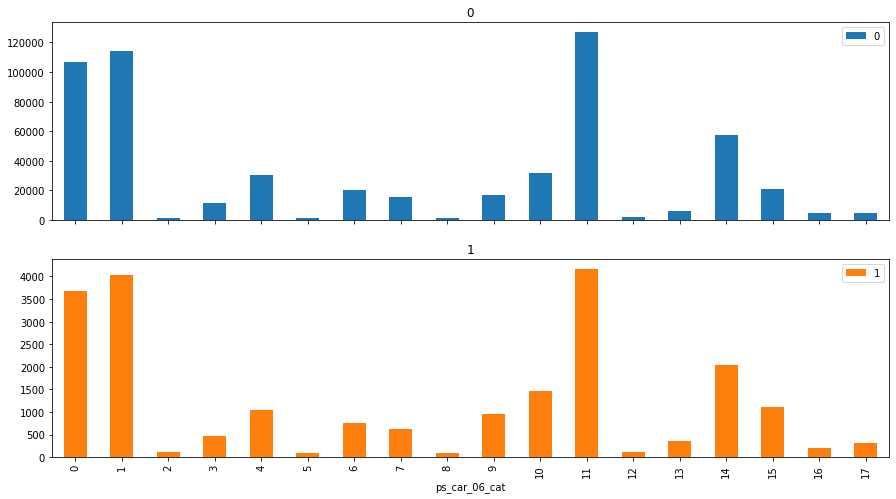

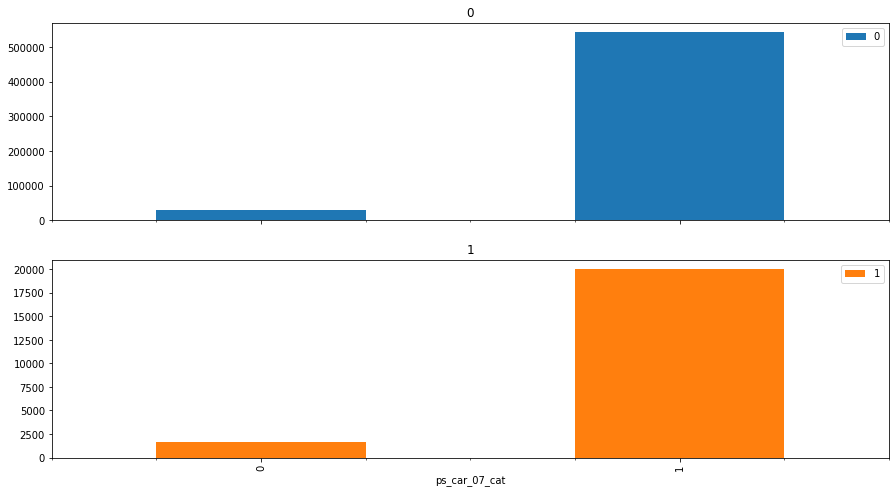

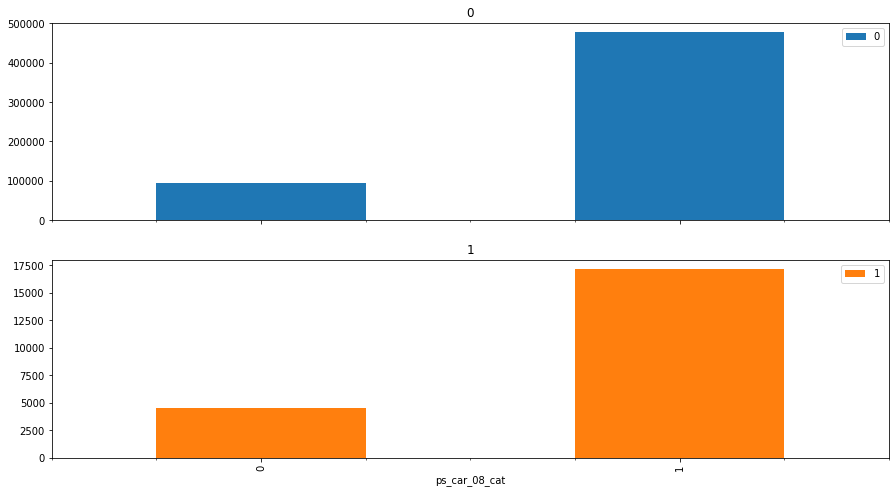

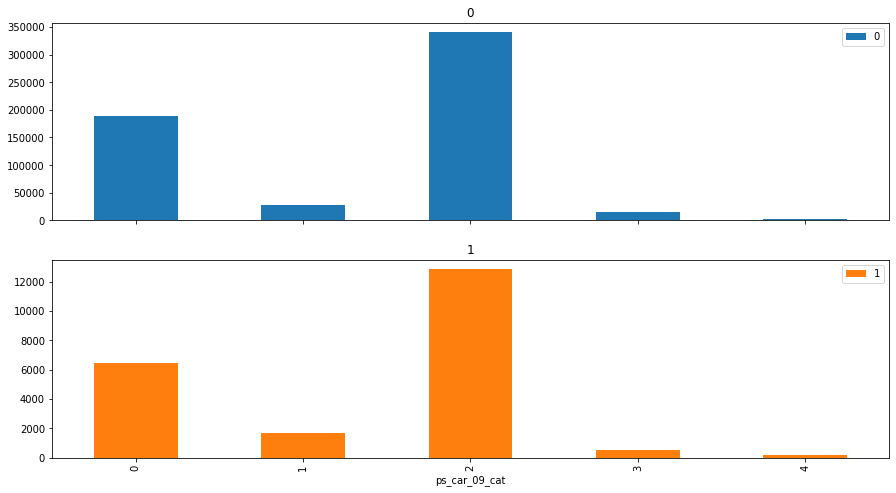

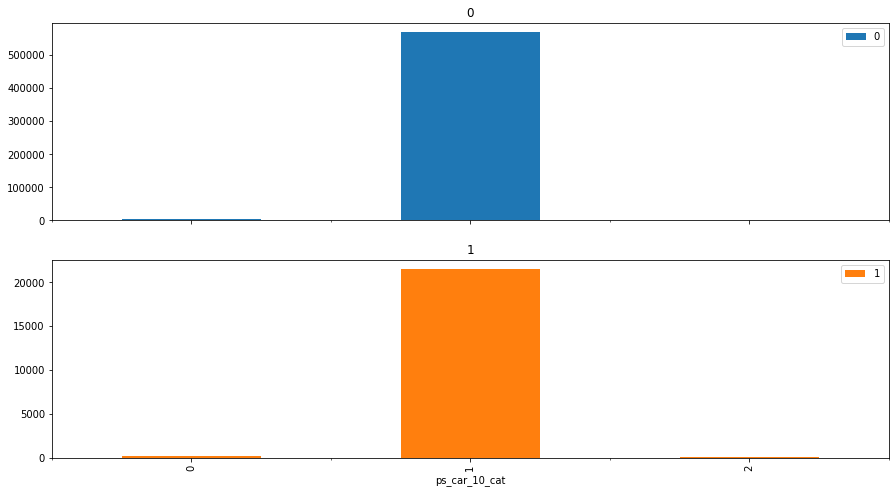

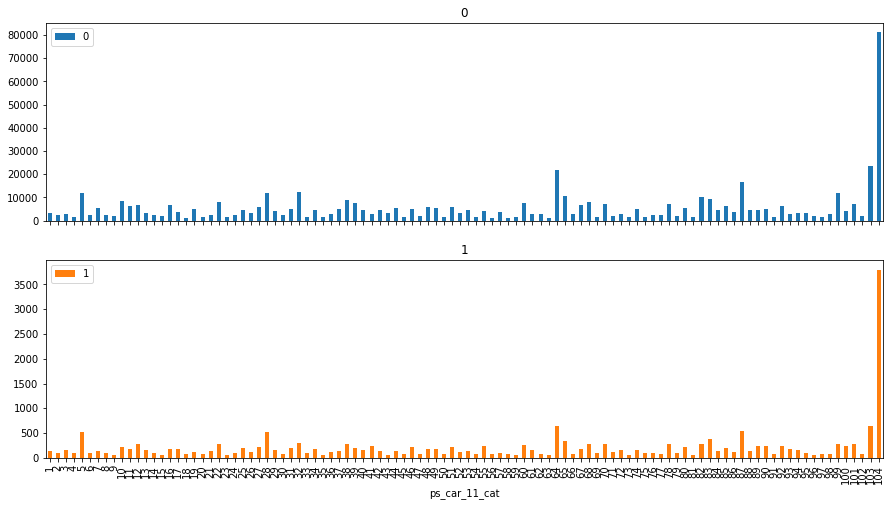

In [109]:
# Plotting the Bi_Variate Graphs
bi_variate_viz(df_cat)


## Inference - Bi_Variate Plots - Categorical Data

    1. Contribution of categories of each features to wards each class are very similar.
    2. There exists no category, which has sole contribution to Class 1

##  Binary Variables

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


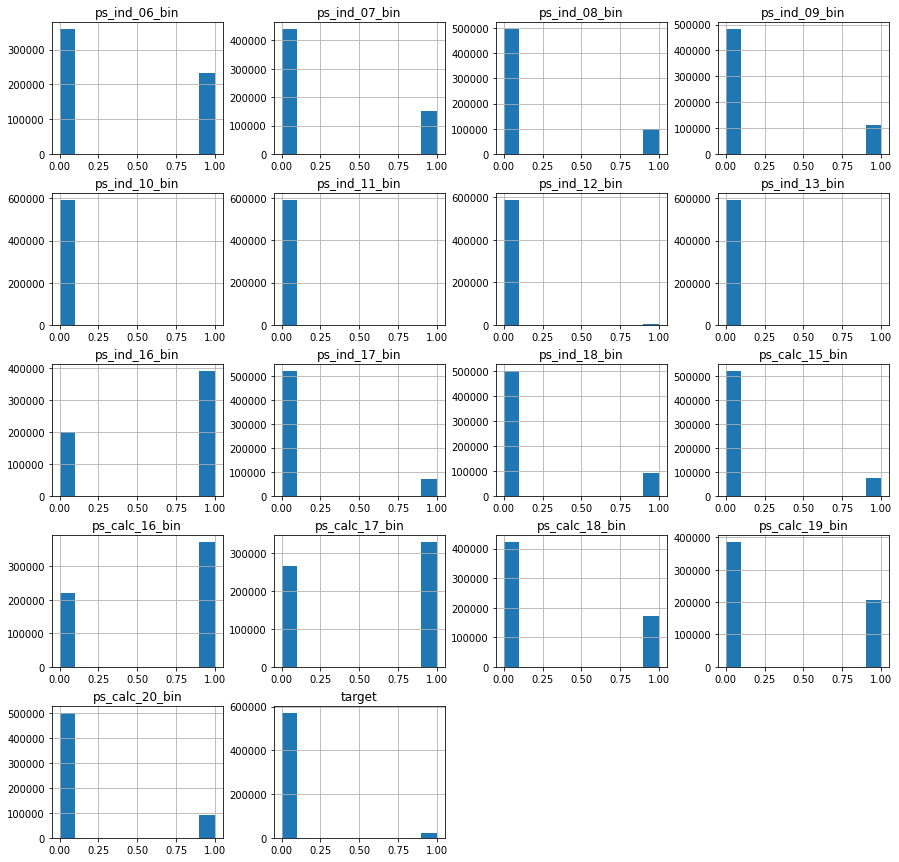

In [110]:
# Histogram for Binary Features

gen_hist(df_data_am_2,bin_col)

In [111]:
df_data_am_2[bin_col].describe()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
count,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000
mean,0.393849,0.256974,0.163869,0.185308,0.000373,0.001691,0.009431,0.000944,0.660931,0.121050,0.153477,0.122450,0.627844,0.554217,0.287142,0.349064,0.153334,0.036373
std,0.488602,0.436965,0.370157,0.388547,0.019321,0.041083,0.096652,0.030706,0.473394,0.326186,0.360447,0.327805,0.483380,0.497052,0.452429,0.476675,0.360309,0.187217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Bi-variate Distribution

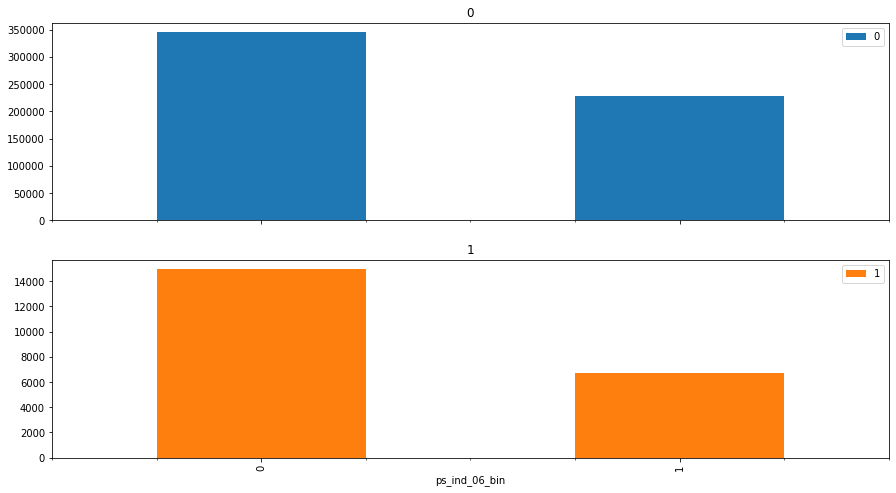

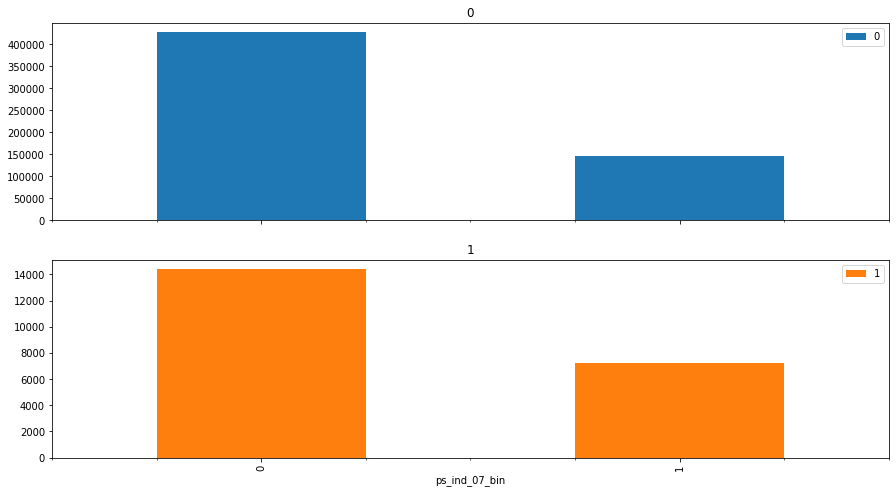

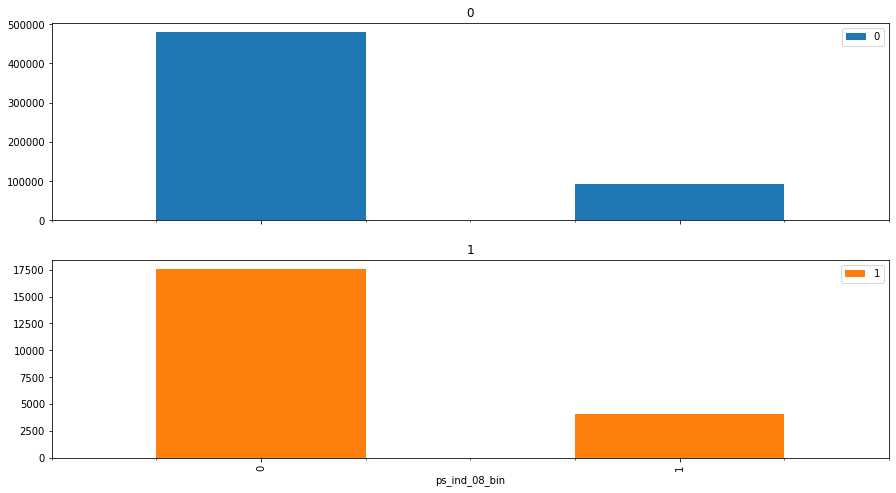

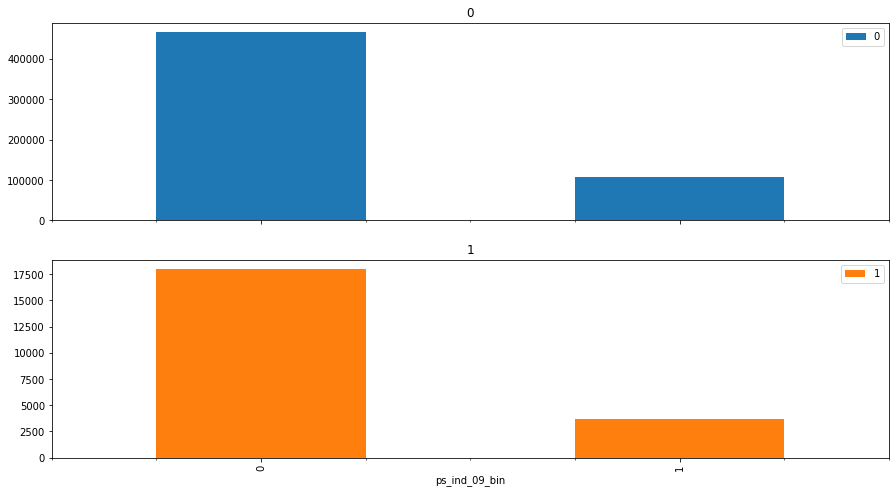

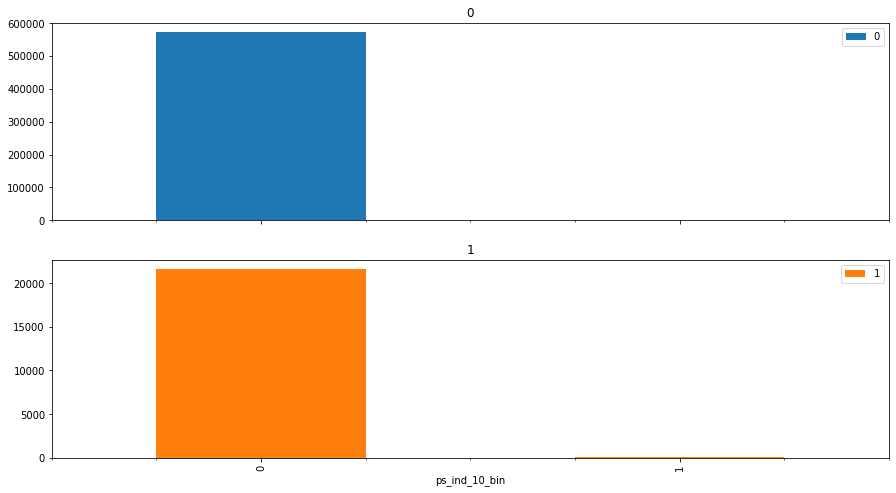

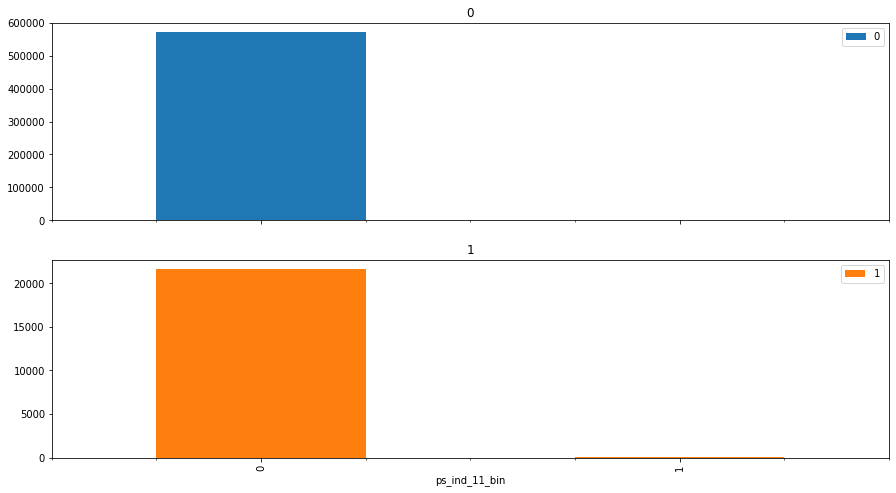

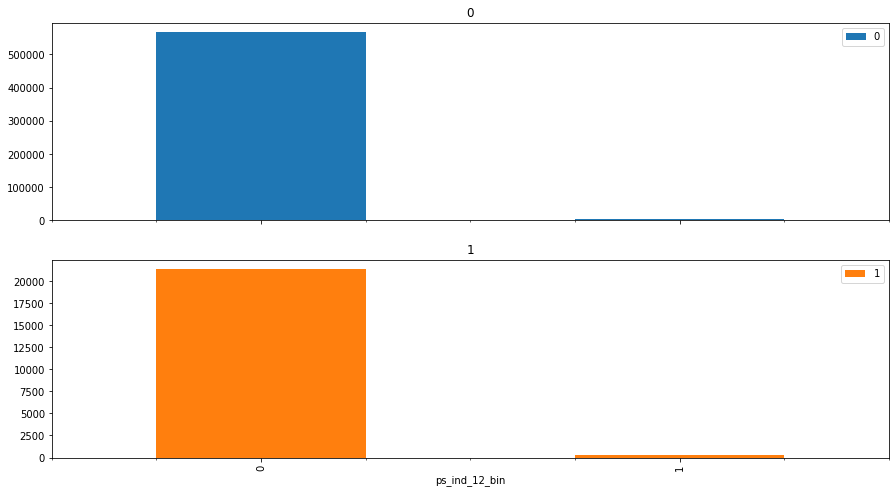

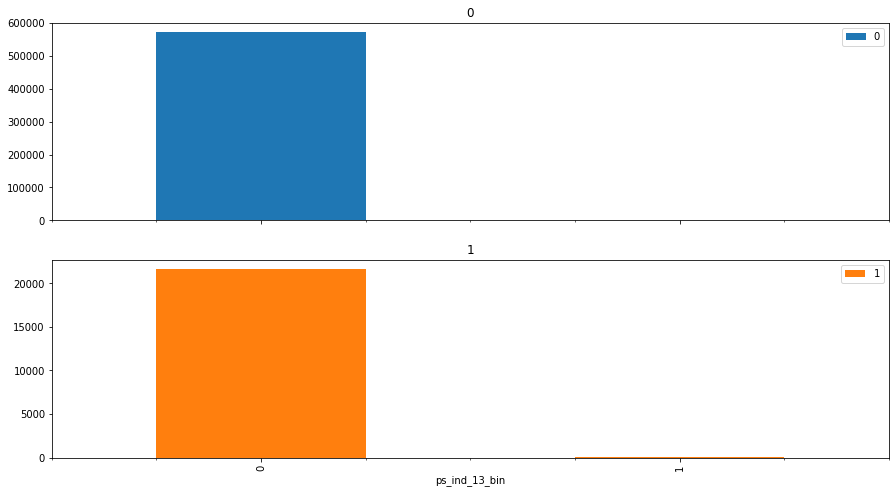

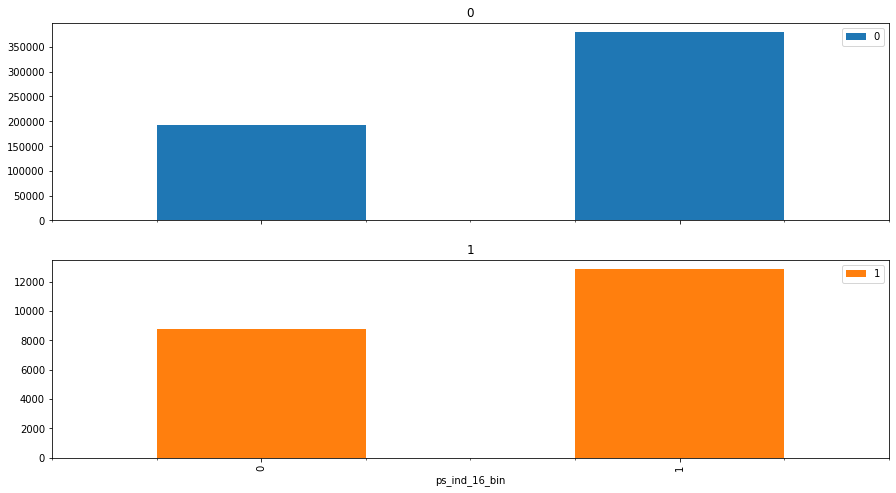

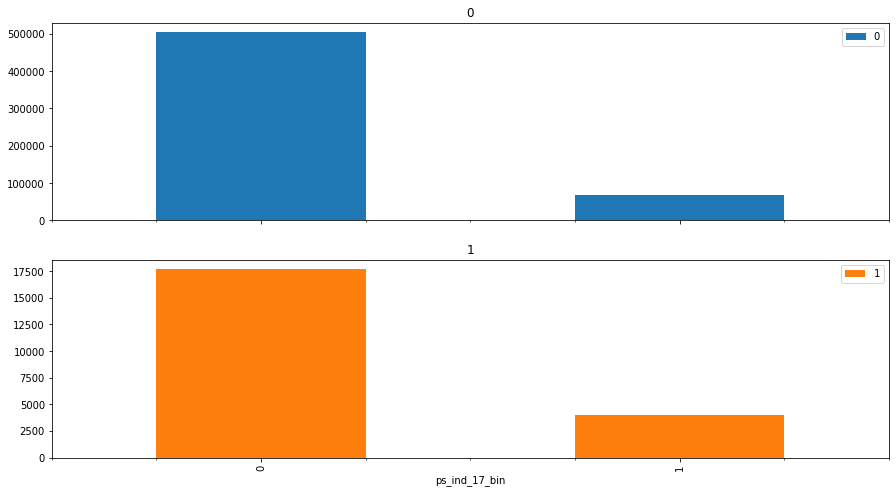

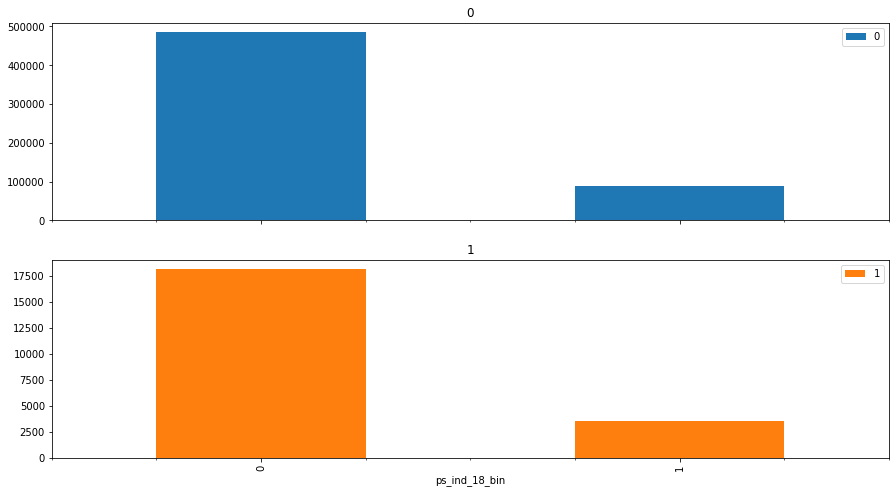

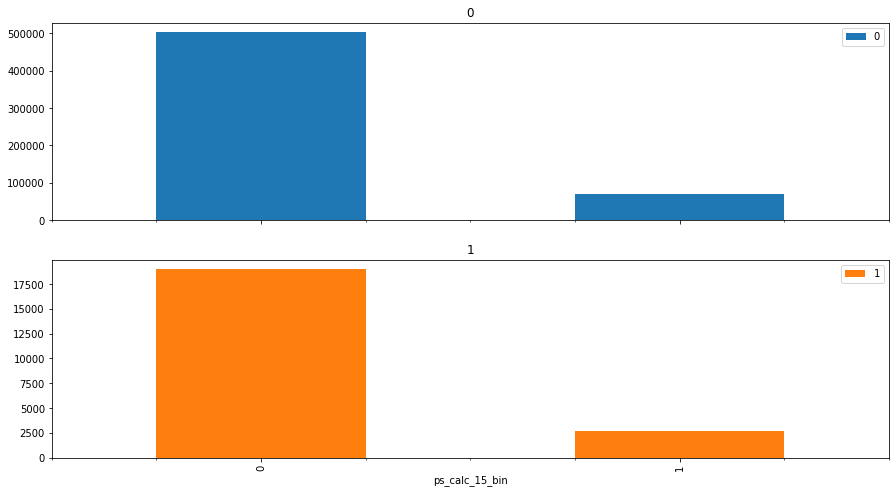

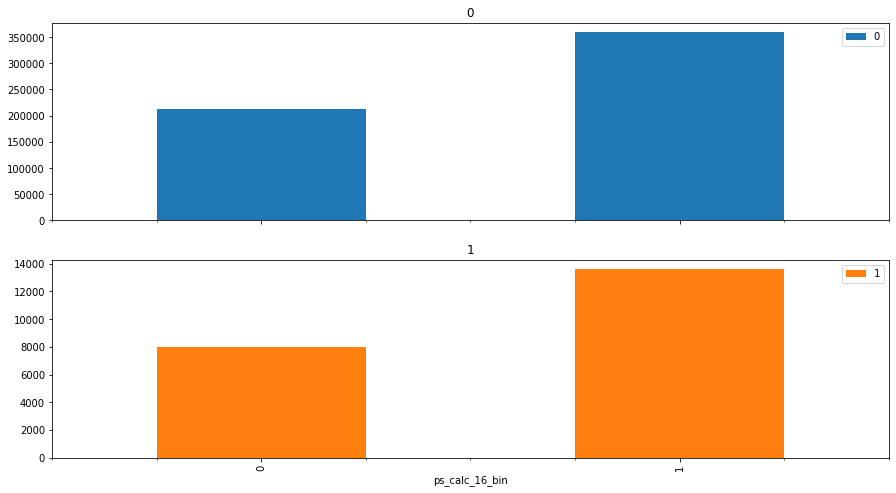

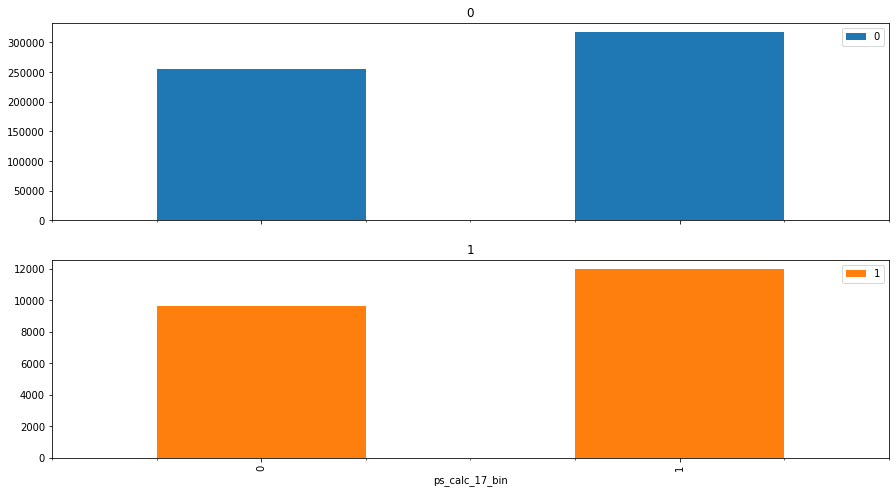

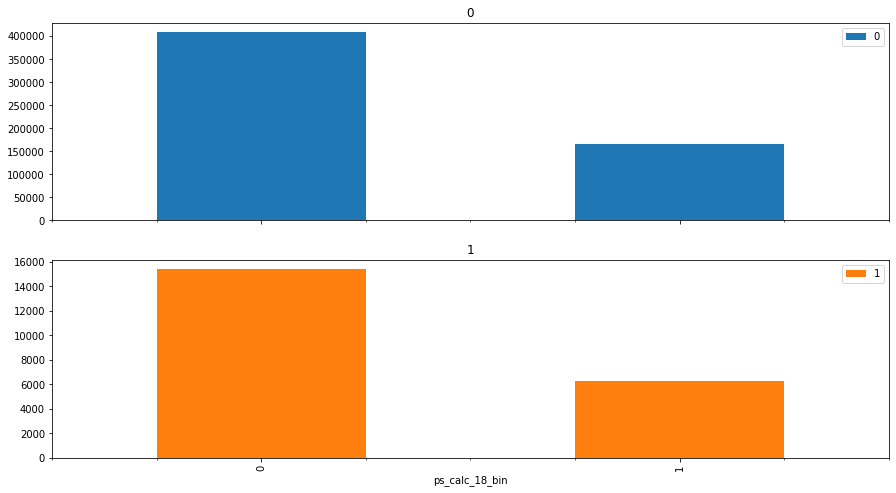

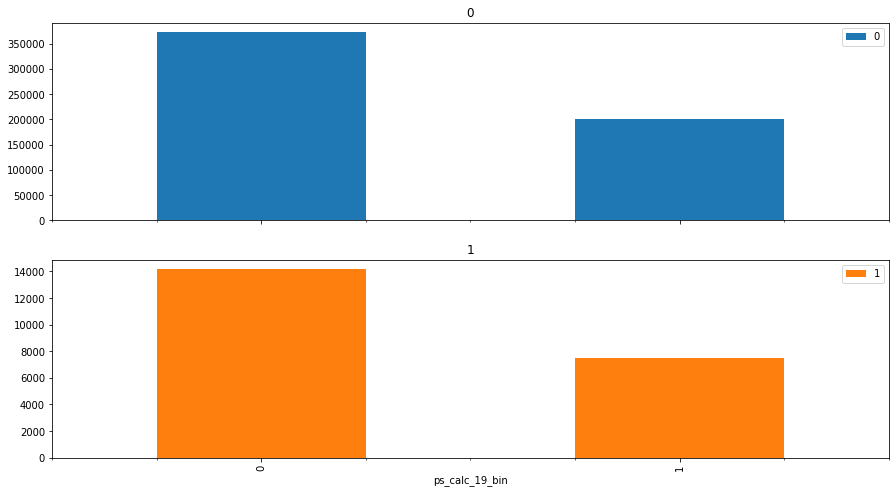

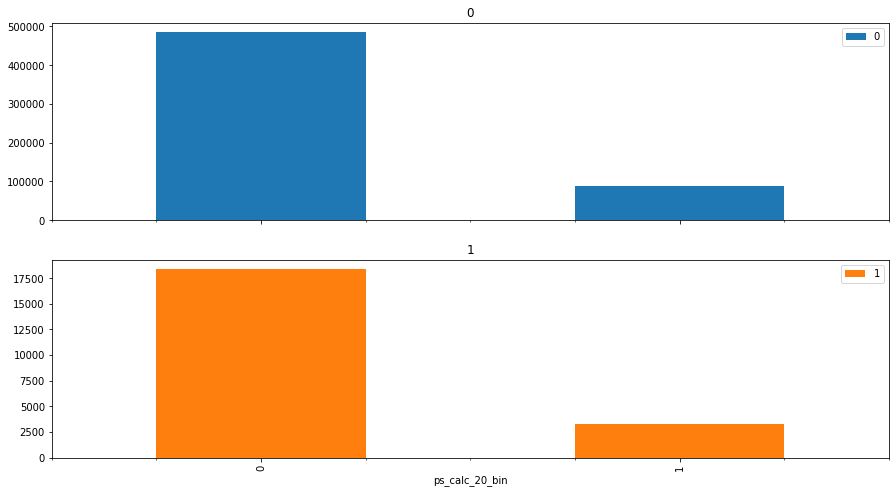

In [112]:
# Plotting the Bi_Variate Graphs
bi_variate_viz(df_data_am_2[bin_col])

## Inference - Binary Variable
    1. Binary Variables contribution of class is similar.

## Ordinal Variables 

In [113]:
df_data_am_2[con_cols_int].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,target
count,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000
mean,1.899991,4.423279,0.012438,7.300036,2.346117,2.372151,1.885943,7.689541,3.005819,9.225796,2.338969,8.433583,5.441276,1.441962,2.872287,7.539274,0.036373
std,1.983264,2.699490,0.127464,3.545902,0.832508,1.117152,1.134882,1.334295,1.414459,1.459625,1.246953,2.904698,2.332842,1.203011,1.694868,2.746651,0.187217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000,0.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000,0.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


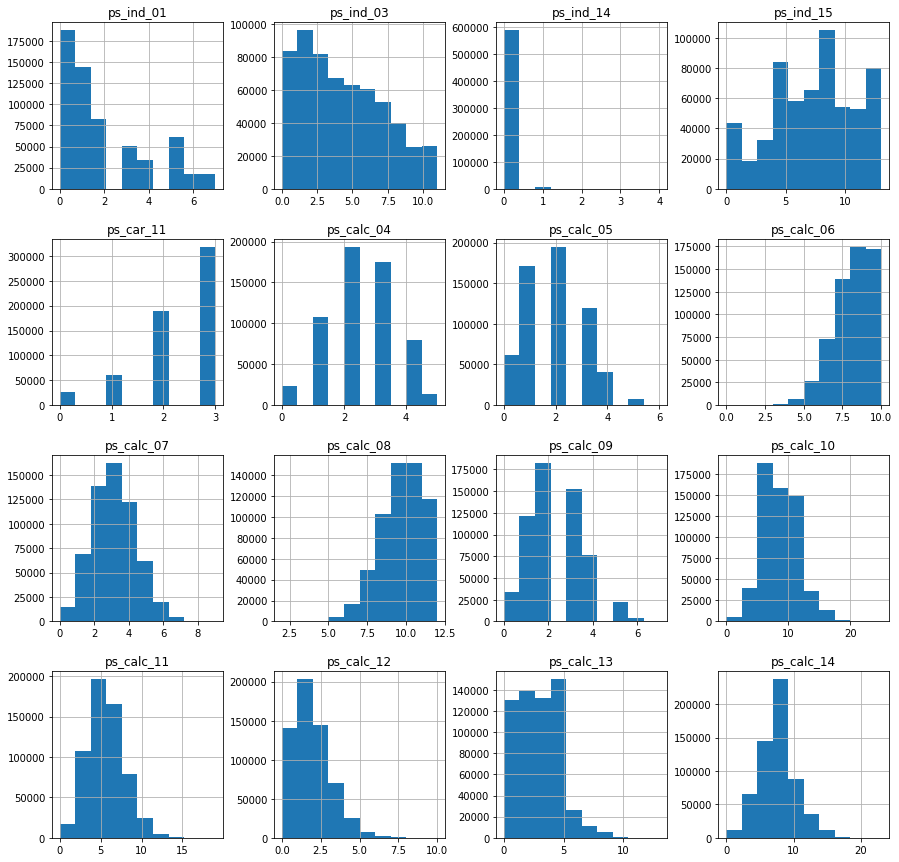

In [114]:
# Histogram for Features
gen_hist(df_data_am_2,con_cols_int[0:-1])

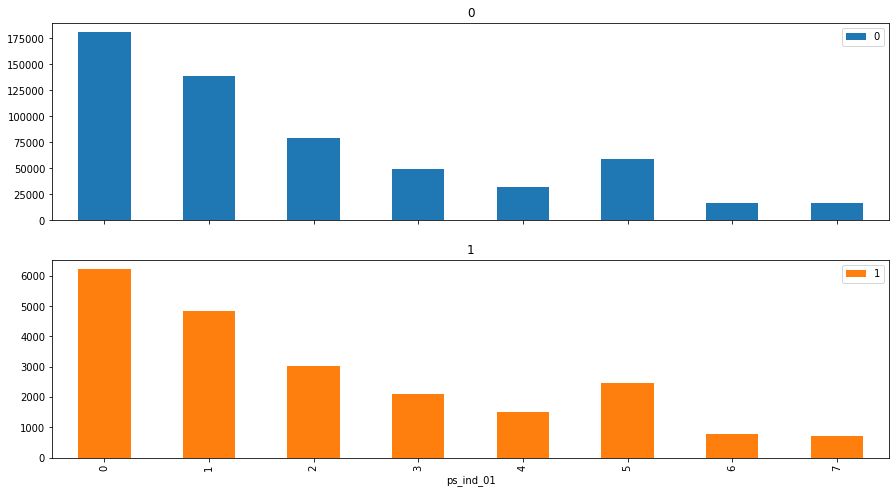

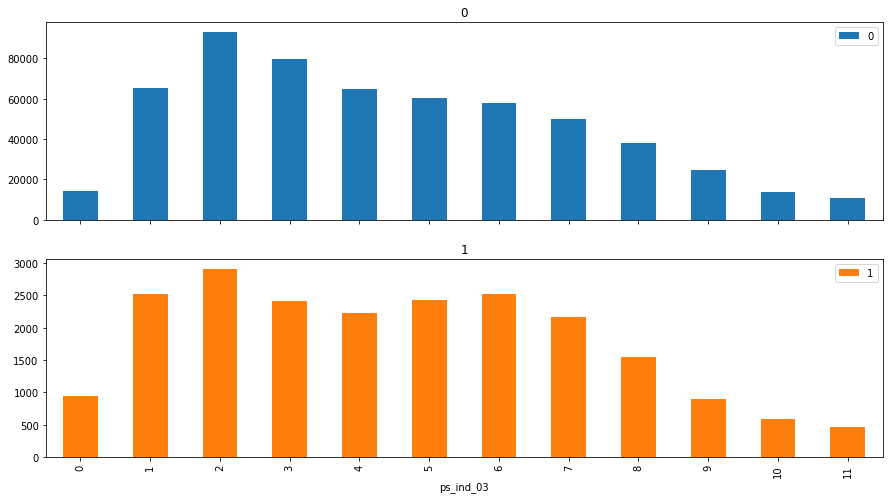

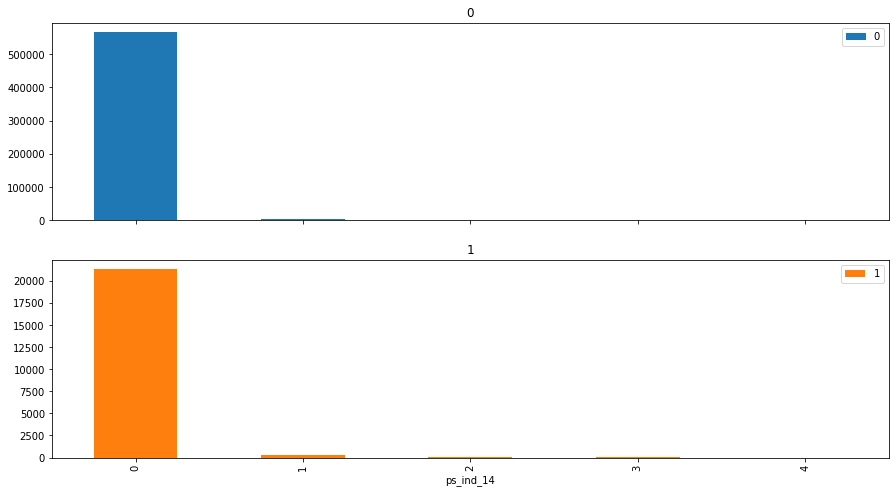

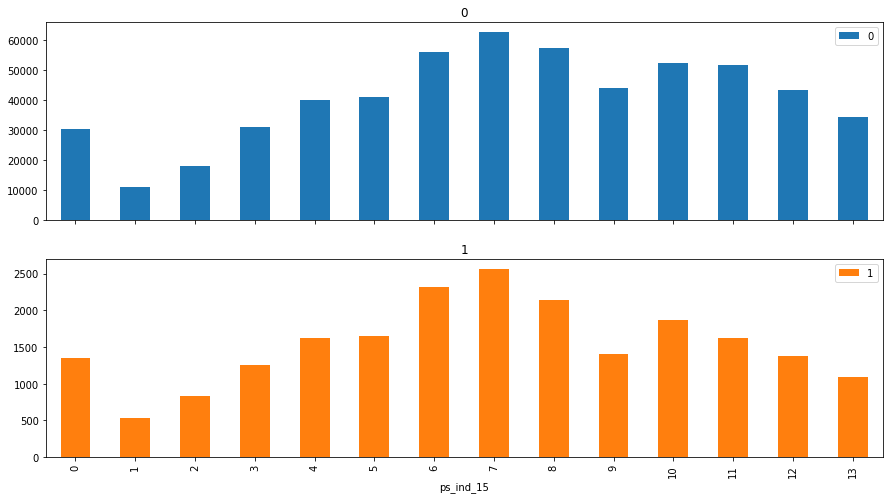

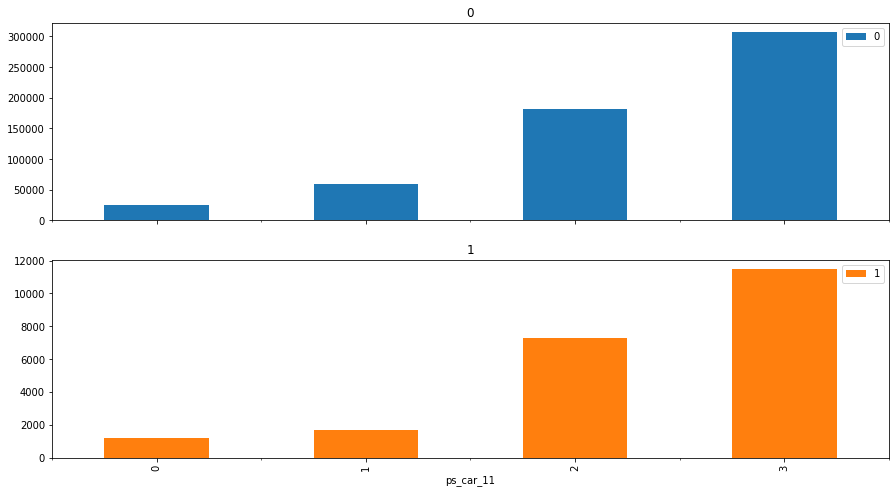

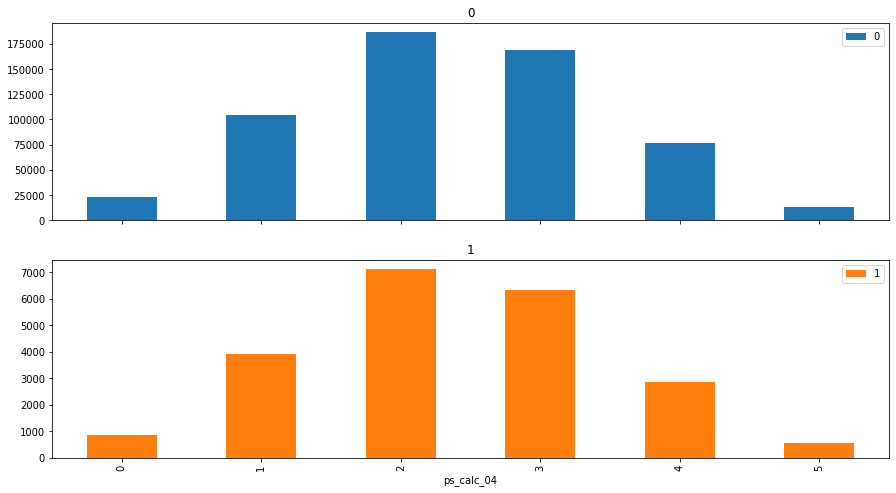

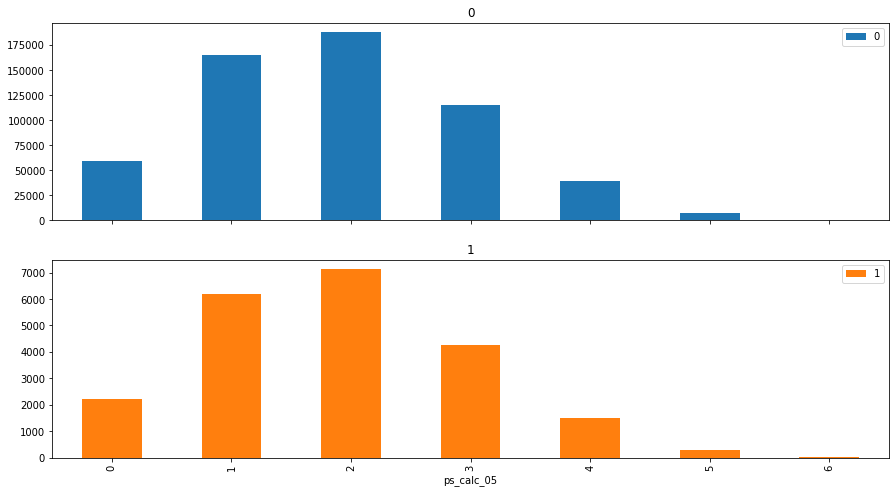

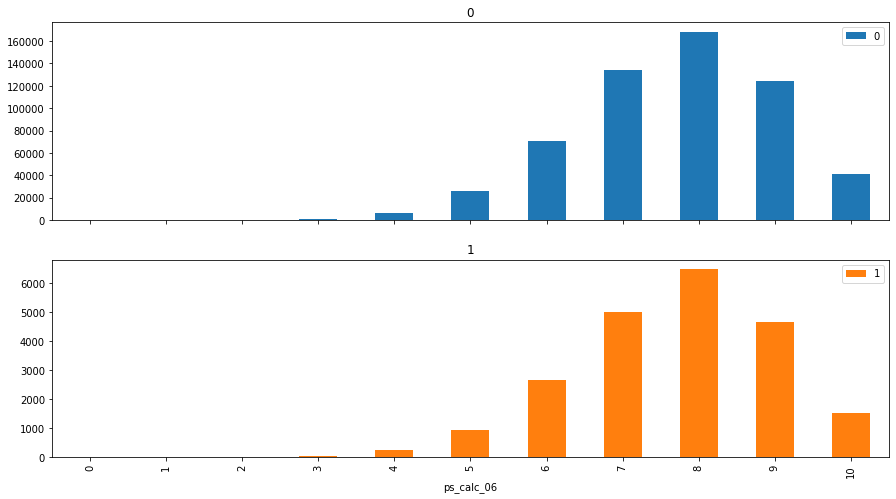

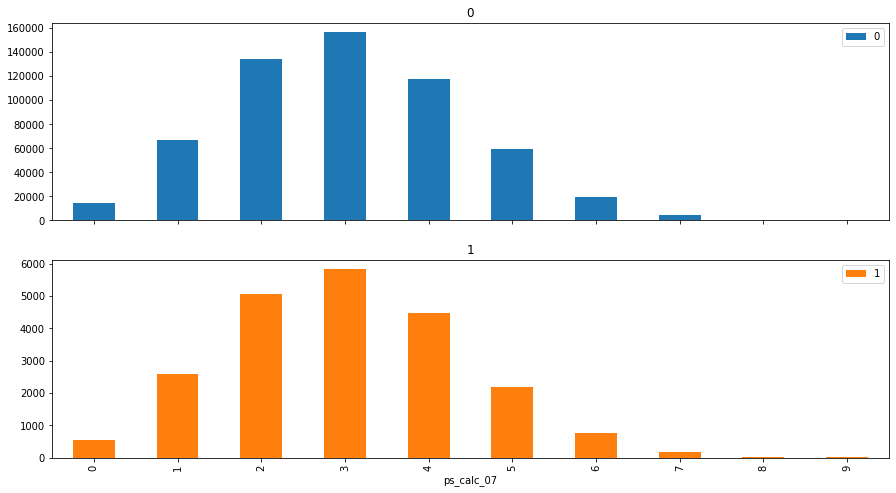

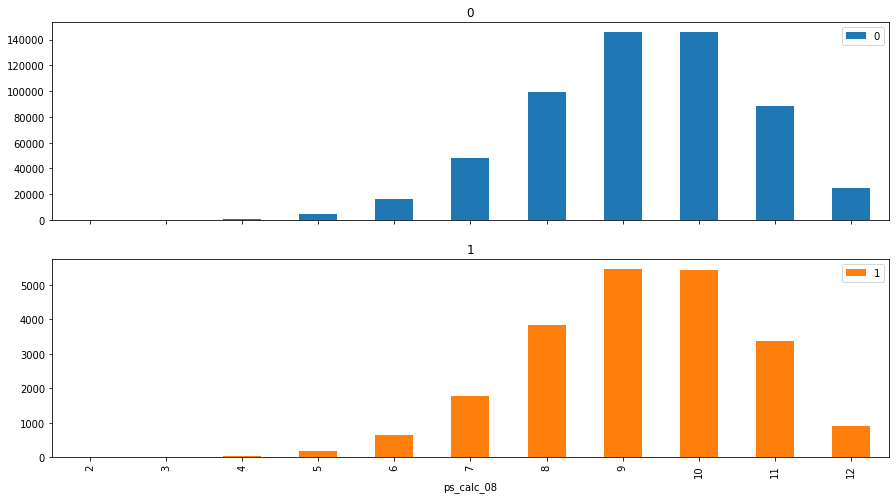

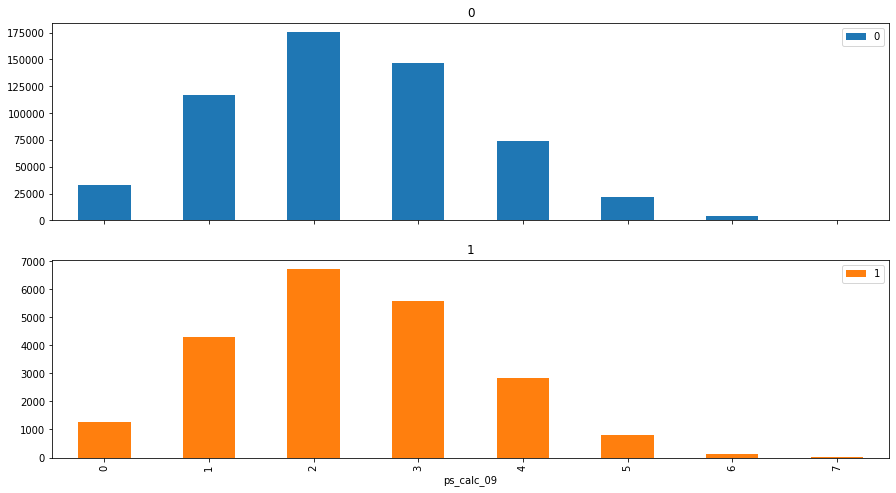

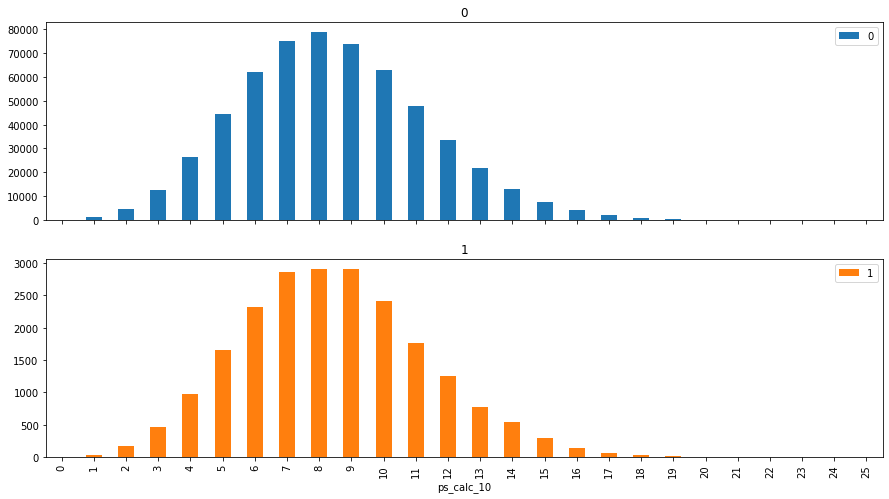

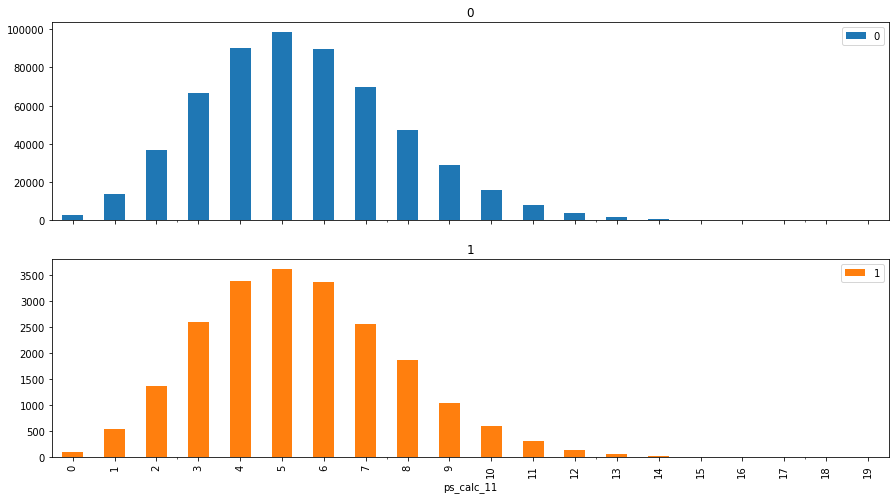

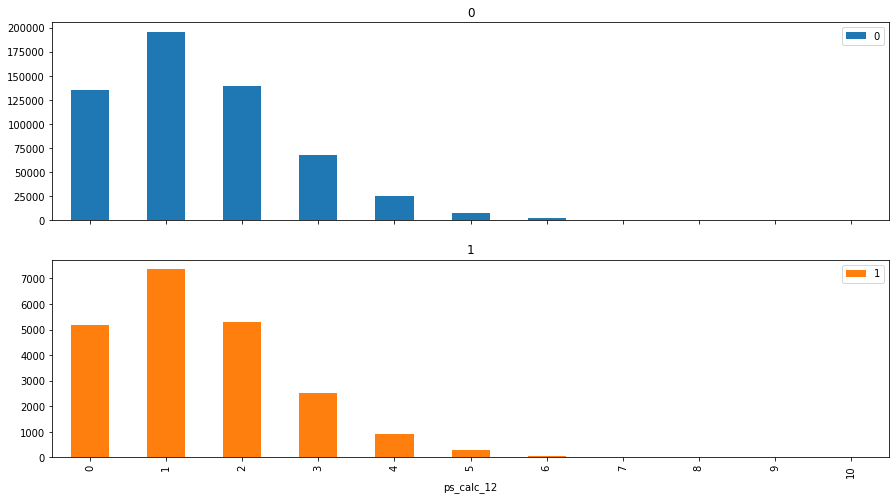

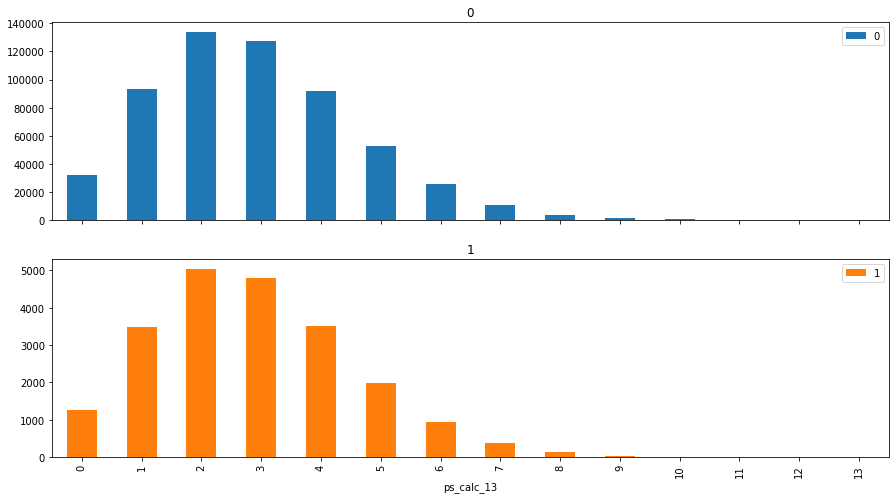

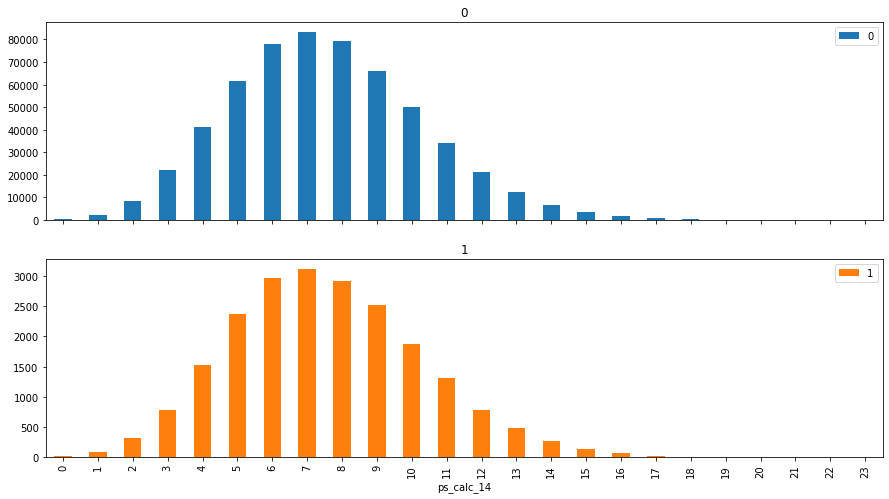

In [115]:
# Plotting the Bi_Variate Graphs
bi_variate_viz(df_data_am_2[con_cols_int])

## Inference - Ordinal Variable
    1. Ordinal Variables variation with respect to its contribution to class is similar for all features.
    2. No features behaving differently for 1 with respect to it behavior towards 0

## Continuous Features - Interval Variables

In [116]:
df_data_am_2[con_cols_flt_interval].describe()

,ps_calc_01,ps_calc_02,ps_calc_03,ps_reg_01,ps_reg_02,target
count,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000
mean,0.449755,0.449562,0.449848,0.611065,0.439172,0.036373
std,0.287200,0.286903,0.287149,0.287572,0.404192,0.187217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.200000,0.200000,0.400000,0.200000,0.000000
50%,0.500000,0.400000,0.500000,0.700000,0.300000,0.000000
75%,0.700000,0.700000,0.700000,0.900000,0.600000,0.000000
max,0.900000,0.900000,0.900000,0.900000,1.800000,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


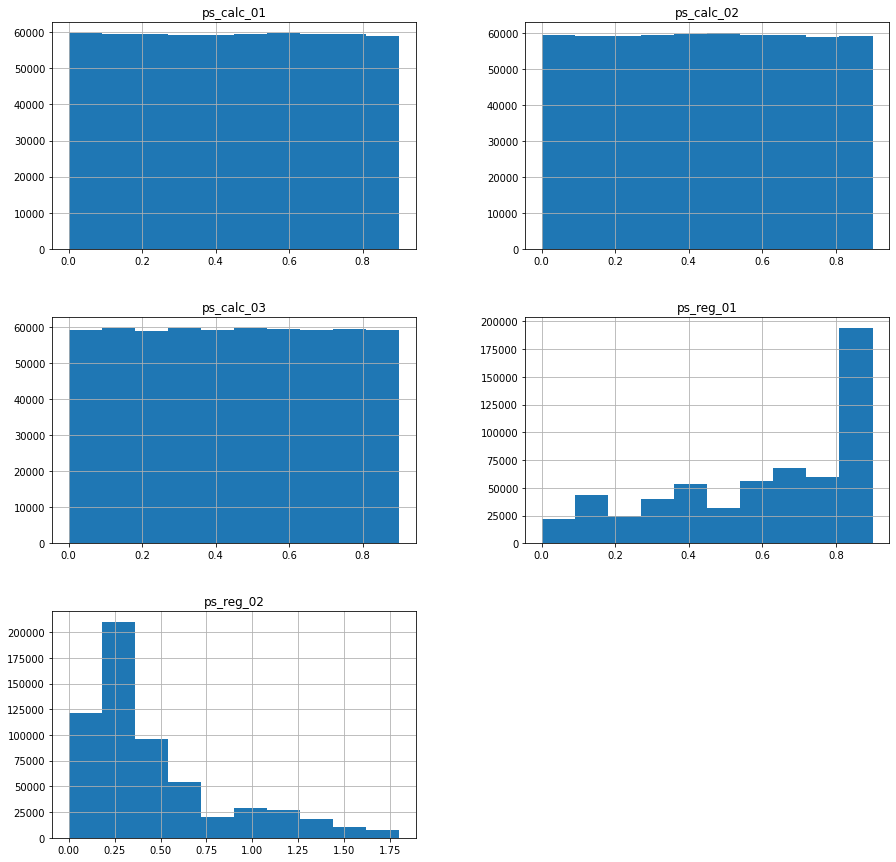

In [117]:
# Histogram for Features
gen_hist(df_data_am_2,con_cols_flt_interval[0:-1])

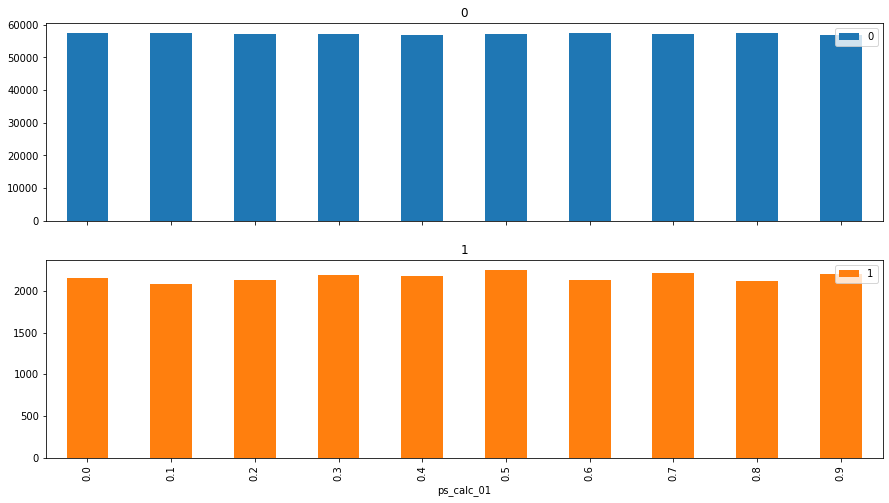

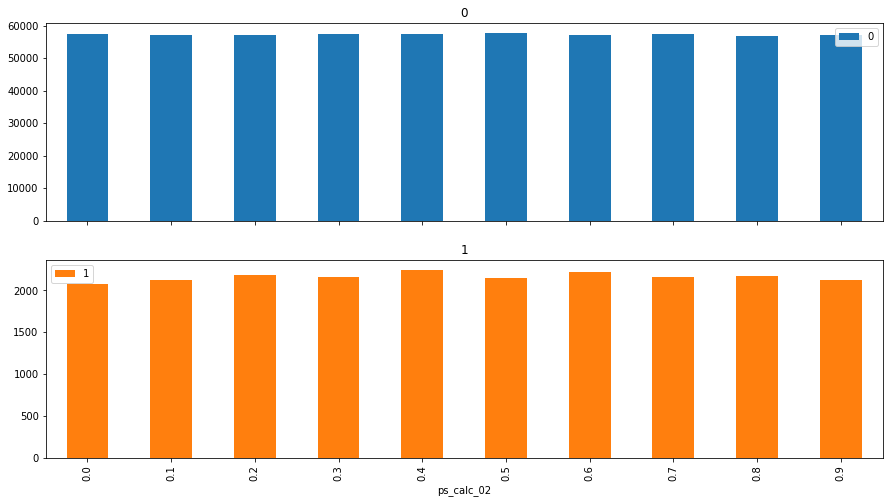

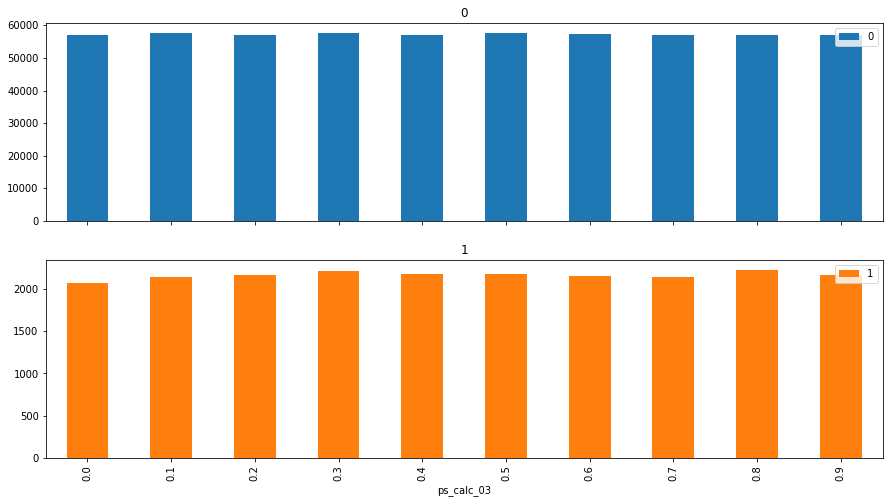

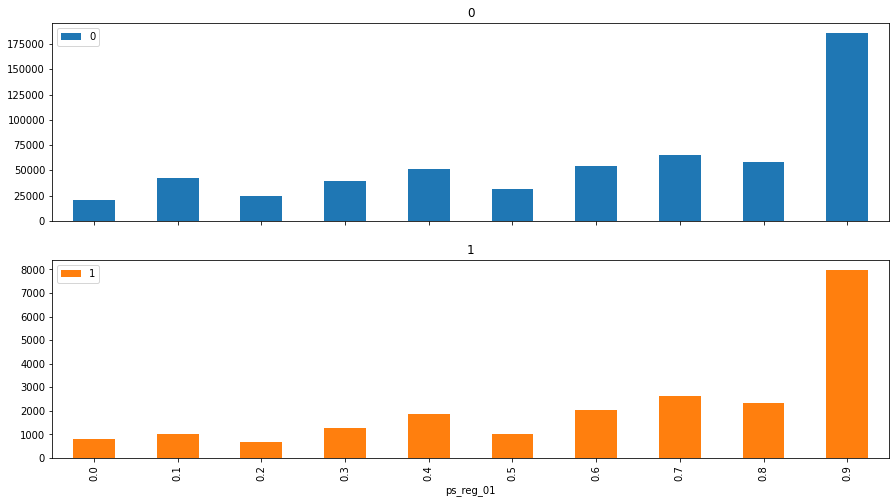

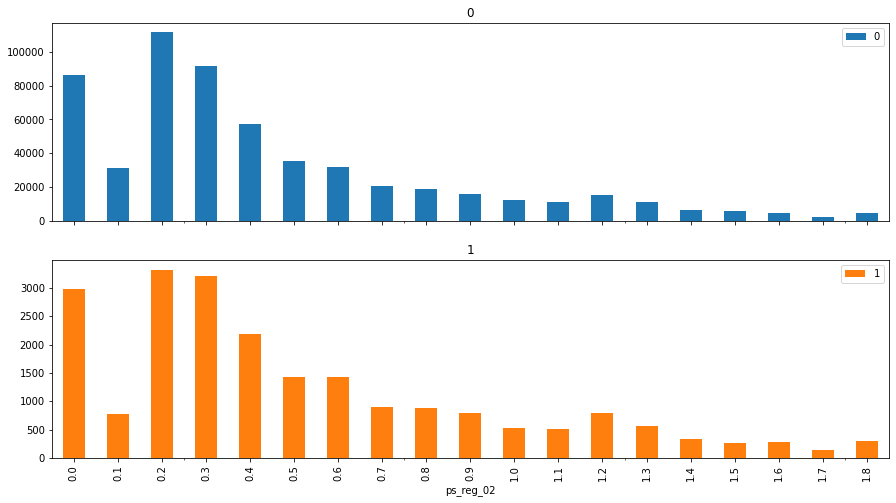

In [118]:
# Plotting the Bi_Variate Graphs
bi_variate_viz(df_data_am_2[con_cols_flt_interval])

## Inference - Continuous Features - Interval Variable
    1. Interval Variables variation with respect to its contribution to class is similar for all features.
    2. No features behaving differently for 1 with respect to it behavior towards 0

## Continuous Features - Interval Variables

In [119]:
df_data_am_2[con_cols_flt_ratio].describe()

,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,target
count,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000
mean,0.877241,0.379915,0.813104,0.374612,3.065838,0.036373
std,0.314554,0.058255,0.224325,0.043935,0.731316,0.187217
min,0.061237,0.100000,0.250619,0.109545,0.000000,0.000000
25%,0.666615,0.316228,0.670836,0.354260,2.828427,0.000000
50%,0.801561,0.374166,0.765811,0.373497,3.316625,0.000000
75%,1.000000,0.400000,0.906100,0.396485,3.605551,0.000000
max,4.037945,1.264911,3.720626,0.636396,3.741657,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


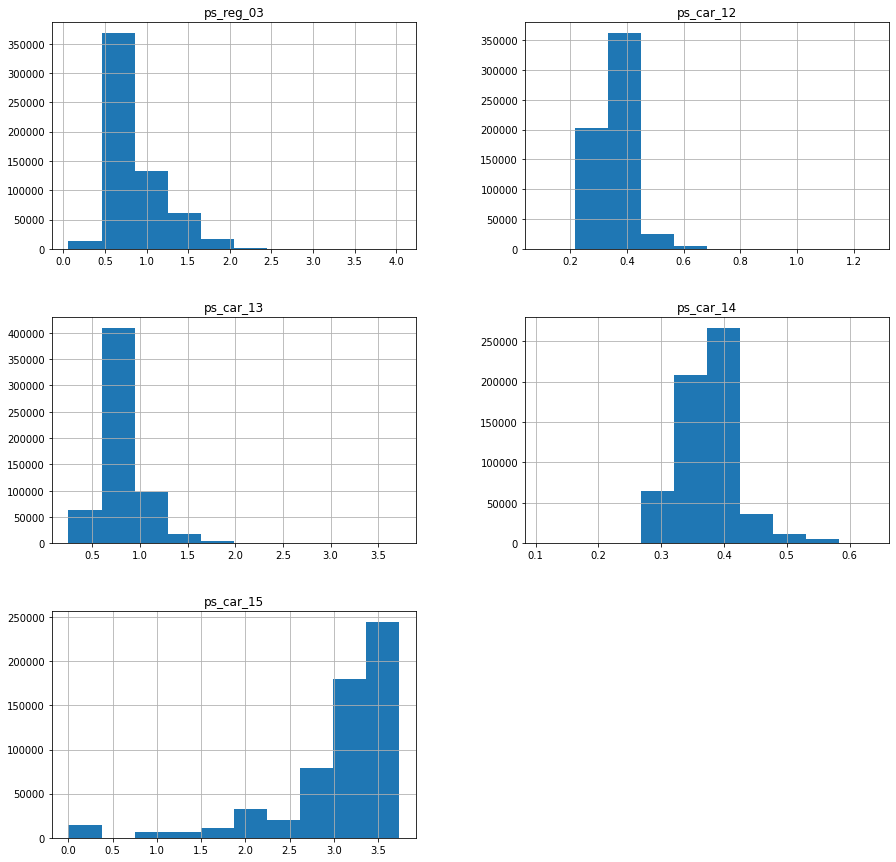

In [120]:
# Histogram for Features
gen_hist(df_data_am_2,con_cols_flt_ratio[0:-1])

## Inference - Continuous Features - Ratio Variable
    1. The datas are positively or negatively skewed, which need to be corrected.


# Creating Datasets for Model Preparation

## Binary Features

In [192]:
df_data_am_2[bin_col[0:-1]].to_pickle(os.path.join(os.getcwd(),'df_bin.pkl')) # Storing all columns execpt the target columns

## Interval Features

In [193]:
df_data_am_2[con_cols_flt_interval[0:-1]].to_pickle(os.path.join(os.getcwd(),'df_con_interval.pkl')) # Storing all columns execpt the target columns
df_con_interval = df_data_am_2[con_cols_flt_interval[0:-1]]

## Ordinal Features

In [194]:
df_data_am_2[con_cols_int[0:-1]].to_pickle(os.path.join(os.getcwd(),'df_con_int.pkl')) # Storing all columns execpt the target columns

## Categoical Features

In [195]:
df_cat_features=copy.deepcopy(df_data_am_2[cat_cols[0:-1]])

In [196]:
df_cat_features.head()

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
0,2,1,0,10,1,0,4,1,0,0,1,12
1,1,0,0,11,1,0,11,1,1,2,1,19
2,4,1,0,7,1,0,14,1,1,2,1,60
3,1,0,0,7,1,0,11,1,1,3,1,104
4,2,1,0,11,1,0,14,1,1,2,1,82


In [197]:
df_cat_features.shape

(594449, 12)

In [198]:
df_cat_obj=df_cat_features.astype('object')

In [199]:
df_cat_obj.dtypes

ps_ind_02_cat    object
ps_ind_04_cat    object
ps_ind_05_cat    object
ps_car_01_cat    object
ps_car_02_cat    object
ps_car_04_cat    object
ps_car_06_cat    object
ps_car_07_cat    object
ps_car_08_cat    object
ps_car_09_cat    object
ps_car_10_cat    object
ps_car_11_cat    object
dtype: object

In [200]:
# Columns for which dummies to be created - target column is removed
col_dum=df_cat_obj.columns.tolist()

In [201]:
# Creating the dataframe of dummies and dropping the first features
df_cat_feat_OHE=pd.get_dummies(df_cat_obj[col_dum],drop_first=True)

In [202]:
df_cat_feat_OHE.head()

,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_1,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_car_01_cat_1,ps_car_01_cat_2,ps_car_01_cat_3,ps_car_01_cat_4,ps_car_01_cat_5,ps_car_01_cat_6,ps_car_01_cat_7,ps_car_01_cat_8,ps_car_01_cat_9,ps_car_01_cat_10,ps_car_01_cat_11,ps_car_02_cat_1,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_06_cat_1,ps_car_06_cat_2,ps_car_06_cat_3,ps_car_06_cat_4,ps_car_06_cat_5,ps_car_06_cat_6,ps_car_06_cat_7,ps_car_06_cat_8,ps_car_06_cat_9,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [203]:
# Storing the Categorical Features without encoding to pickle file
df_cat_features.to_pickle(os.path.join(os.getcwd(),'df_cat_w_o_OHE.pkl'))

In [204]:
# Storing the Categorical Features with encoding to pickle file
df_cat_feat_OHE.to_pickle(os.path.join(os.getcwd(),'df_cat_w_OHE.pkl'))

## Ratio Variables

In [205]:
df_con_ratio=copy.deepcopy(df_data_am_2[con_cols_flt_ratio[0:-1]])
df_con_ratio.describe()

,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15
count,594449.000000,594449.000000,594449.000000,594449.000000,594449.000000
mean,0.877241,0.379915,0.813104,0.374612,3.065838
std,0.314554,0.058255,0.224325,0.043935,0.731316
min,0.061237,0.100000,0.250619,0.109545,0.000000
25%,0.666615,0.316228,0.670836,0.354260,2.828427
50%,0.801561,0.374166,0.765811,0.373497,3.316625
75%,1.000000,0.400000,0.906100,0.396485,3.605551
max,4.037945,1.264911,3.720626,0.636396,3.741657


In [206]:
# checking the skewness of the data for datas which are float type 
# Univariate Distribution 

skew_flt=df_con_ratio.skew()
skew_flt

ps_reg_03    1.310307
ps_car_12    1.085101
ps_car_13    1.699083
ps_car_14    0.698595
ps_car_15   -2.216005
dtype: float64

In [207]:
# Boxcox transformation cannot be done on features having 0 values
# Seggregating the feature having 0 values and those having only non-zero(strictly positive values)

col_greater_0=[]  
col_with_0=[]  
for col in df_con_ratio.columns.tolist():
    if df_con_ratio[col].min()>0:
        col_greater_0.append(col)
    else:
        col_with_0.append(col)    
        

In [208]:
print("Columns having values greater than Zero ", col_greater_0,'\n')
print("Columns having values including Zero ", col_with_0,'\n')

Columns having values greater than Zero  ['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14'] 

Columns having values including Zero  ['ps_car_15'] 



### Checking the best possible transformation to reduce the skewness in the data for features NOT having 0 values.

In [209]:
print(df_con_ratio[col_greater_0].skew())

ps_reg_03    1.310307
ps_car_12    1.085101
ps_car_13    1.699083
ps_car_14    0.698595
dtype: float64


In [210]:
from scipy.stats import boxcox

In [211]:
# Function to plot the tranformation diagram
def trf_diag(df,col,trf_sr):
    fig=plt.figure(figsize=(15,15))
    ax1=fig.add_subplot(221)
    ax1.set_title('Histogram before transformation')
    df[col].hist()

    ax2 = fig.add_subplot(222)
    ax2.set_title('Histogram after transformation')
    trf_sr.hist()
    
    print("Skew Before Transformation : ", np.round(df[col].skew(),3), '\n')
    print("Skew After  Transformation : ", np.round(trf_sr.skew(),3), '\n')


In [212]:
col_greater_0

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']

In [213]:
trf_dict={}
dict_final={}
for col in col_greater_0:
    log_trf=pd.Series(np.log(df_con_ratio[col]))
    bcox_trf,_=boxcox(df_con_ratio[col])
    bcox_trf=pd.Series(bcox_trf)
    sqrt_trf=pd.Series(np.sqrt(df_con_ratio[col]))
    trf_dict['skew_b4_trf']=np.round(df_con_ratio[col].skew(),3)
    trf_dict['log_trf']=np.round(log_trf.skew(),3)
    trf_dict['bcox_trf']=np.round(bcox_trf.skew(),3)
    trf_dict['sqrt_trf']=np.round(sqrt_trf.skew(),3)
    dict_final[col]=trf_dict
    trf_dict={}
    
df_dict=pd.DataFrame(dict_final).transpose()

In [214]:
df_dict

,skew_b4_trf,log_trf,bcox_trf,sqrt_trf
ps_reg_03,1.310,0.361,-0.018,0.843
ps_car_12,1.085,0.420,-0.010,0.695
ps_car_13,1.699,0.532,-0.027,1.068
ps_car_14,0.699,0.001,-0.000,0.363


Log Transformation : ps_reg_03 

Skew Before Transformation :  1.31 

Skew After  Transformation :  0.361 



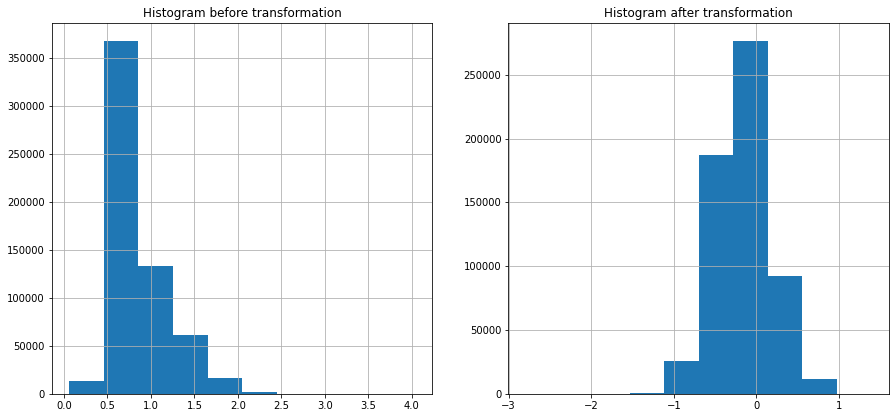

In [215]:
#log Transformation
print("Log Transformation : {}".format('ps_reg_03'),'\n')
log_trf=pd.Series(np.log(df_con_ratio['ps_reg_03']))
trf_diag(df_con_ratio,'ps_reg_03',log_trf)

### Inference

    1. From the above table it is clear, the lowest skew is provided by log transformation


### Checking the best possible transformation to reduce the skewness in the data for features HAVING 0 values.

In [216]:
trf_dict={}
dict_final={}
for col in col_with_0:
    log_trf=pd.Series(np.log1p(df_con_ratio[col]))
    sqrt_trf=pd.Series(np.sqrt(df_con_ratio[col]))
    trf_dict['skew_b4_trf']=np.round(df_con_ratio[col].skew(),3)
    trf_dict['log_trf_1p']=np.round(log_trf.skew(),3)
    trf_dict['sqrt_trf']=np.round(sqrt_trf.skew(),3)
    dict_final[col]=trf_dict
    trf_dict={}
    
df_dict_w0=pd.DataFrame(dict_final).transpose()

In [217]:
# Checked for log(1+x) transformation
df_dict_w0

,log_trf_1p,skew_b4_trf,sqrt_trf
ps_car_15,-3.634,-2.216,-3.917


### Inference

    1. Log(1+x) and sqrt transformation is increasing the skew
    2. Introducing a very low value, just to make it true positive to apply boxcox

In [218]:
# Applying log-Transformation to features with out Zero value

for col in col_greater_0:
    df_con_ratio[col]=np.log(df_con_ratio[col])

In [219]:
# Applying Box-Cox to features with Zero value

print("Columns with Zero", col_with_0)

Columns with Zero ['ps_car_15']


In [220]:
# Modifying Zero values to be just positive - arbitarily choosing the value of 0.001 to replace in the features

for col in col_with_0:
    mod_sr=pd.Series(np.where(df_con_ratio[col].values==0,0.01,df_con_ratio[col].values))
    bcox_trf,_=boxcox(mod_sr)
    df_con_interval[col]=bcox_trf
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [221]:
df_con_interval.skew()

ps_calc_01   -0.001108
ps_calc_02    0.001153
ps_calc_03    0.000821
ps_reg_01    -0.639500
ps_reg_02     1.281203
ps_car_15    -1.004886
dtype: float64

In [222]:
# Final Dataframe after skew adjustment
df_con_ratio_sk=copy.deepcopy(df_con_ratio)

In [223]:
df_con_ratio_sk.to_pickle(os.path.join(os.getcwd(),'df_con_ratio_sk.pkl'))

# Preparing 2 Sets of data

##  With OHE of Categorical Features.

### Reading from pickle file

In [224]:
df_bin= pd.read_pickle(os.path.join(os.getcwd(),'df_bin.pkl'))
df_con_interval= pd.read_pickle(os.path.join(os.getcwd(),'df_con_interval.pkl'))
df_con_int= pd.read_pickle(os.path.join(os.getcwd(),'df_con_int.pkl'))
df_cat_w_OHE= pd.read_pickle(os.path.join(os.getcwd(),'df_cat_w_OHE.pkl'))
df_con_ratio_sk= pd.read_pickle(os.path.join(os.getcwd(),'df_con_ratio_sk.pkl'))

In [225]:
df_data_am_2= pd.read_pickle(os.path.join(os.getcwd(),'df_no_unfill.pkl'))

In [226]:
# Concatenation
df_temp_concat=pd.concat([df_bin,df_con_interval], axis=1)
df_temp_concat=pd.concat([df_temp_concat,df_con_int], axis=1)
df_temp_concat=pd.concat([df_temp_concat,df_cat_w_OHE], axis=1)
df_data_w_OHE=pd.concat([df_temp_concat,df_con_ratio_sk], axis=1)


In [227]:
df_data_w_OHE.shape

(594449, 202)

In [228]:
df_data_am_2.target.shape

(594449,)

In [229]:
df_data_w_OHE['target']=df_data_am_2.target.values

In [230]:
df_data_w_OHE.head()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_calc_01,ps_calc_02,ps_calc_03,ps_reg_01,ps_reg_02,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_ind_02_cat_2,ps_ind_02_cat_3,...,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,target
0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0.6,0.5,0.2,0.7,0.2,2,5,0,11,2,3,1,10,1,10,1,5,9,1,5,8,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.331188,-0.916291,-0.123661,-0.992066,3.605551,0
1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0.3,0.1,0.3,0.8,0.4,1,7,0,3,3,2,1,9,5,8,1,7,3,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.266472,-1.151293,-0.479946,-0.944907,2.449490,0
2,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0.5,0.7,0.1,0.0,0.0,5,9,0,12,1,2,2,9,1,8,2,7,4,2,7,7,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.221194,-1.151293,-0.443812,-1.057638,3.316625,0
3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.6,0.9,0.1,0.9,0.2,0,2,0,8,1,2,4,7,1,8,4,2,2,2,4,9,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.543095,-0.983056,-0.610740,-1.220924,2.000000,0
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0.4,0.6,0.0,0.7,0.6,0,0,0,9,3,2,2,6,3,10,2,12,3,1,1,3,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.173451,-1.151793,-0.569459,-1.007577,2.000000,0


In [231]:
## Storing the dataframe with encoded categorical data in pickle file
df_data_w_OHE.to_pickle(os.path.join(os.getcwd(),'df_combo_w_OHE.pkl'))

##  Without OHE of Categorical Features.

In [232]:
df_cat_w_o_OHE= pd.read_pickle(os.path.join(os.getcwd(),'df_cat_w_o_OHE.pkl'))

In [233]:
# Concatenation
df_temp_concat=pd.concat([df_bin,df_con_interval], axis=1)
df_temp_concat=pd.concat([df_temp_concat,df_con_int], axis=1)
df_temp_concat=pd.concat([df_temp_concat,df_cat_w_o_OHE], axis=1)
df_data_w_o_OHE=pd.concat([df_temp_concat,df_con_ratio_sk], axis=1)
df_data_w_o_OHE['target']=df_data_am_2.target.values

In [234]:
df_data_w_o_OHE.shape

(594449, 56)

In [235]:
df_data_w_o_OHE.head()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_calc_01,ps_calc_02,ps_calc_03,ps_reg_01,ps_reg_02,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,target
0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0.6,0.5,0.2,0.7,0.2,2,5,0,11,2,3,1,10,1,10,1,5,9,1,5,8,2,1,0,10,1,0,4,1,0,0,1,12,-0.331188,-0.916291,-0.123661,-0.992066,3.605551,0
1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0.3,0.1,0.3,0.8,0.4,1,7,0,3,3,2,1,9,5,8,1,7,3,1,1,9,1,0,0,11,1,0,11,1,1,2,1,19,-0.266472,-1.151293,-0.479946,-0.944907,2.449490,0
2,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0.5,0.7,0.1,0.0,0.0,5,9,0,12,1,2,2,9,1,8,2,7,4,2,7,7,4,1,0,7,1,0,14,1,1,2,1,60,-0.221194,-1.151293,-0.443812,-1.057638,3.316625,0
3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.6,0.9,0.1,0.9,0.2,0,2,0,8,1,2,4,7,1,8,4,2,2,2,4,9,1,0,0,7,1,0,11,1,1,3,1,104,-0.543095,-0.983056,-0.610740,-1.220924,2.000000,0
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0.4,0.6,0.0,0.7,0.6,0,0,0,9,3,2,2,6,3,10,2,12,3,1,1,3,2,1,0,11,1,0,14,1,1,2,1,82,-0.173451,-1.151793,-0.569459,-1.007577,2.000000,0


## Inference

    1. Increase in no. of features after encoding is 147

In [236]:
## Storing the dataframe with encoded categorical data in pickle file
df_data_w_o_OHE.to_pickle(os.path.join(os.getcwd(),'df_combo_w_o_OHE.pkl'))

# Reading the Combo Data from pickle file

In [237]:
df_data_w_OHE= pd.read_pickle(os.path.join(os.getcwd(),'df_combo_w_OHE.pkl'))

In [238]:
df_data_w_o_OHE= pd.read_pickle(os.path.join(os.getcwd(),'df_combo_w_o_OHE.pkl'))

In [239]:
df_con_ratio_sk= pd.read_pickle(os.path.join(os.getcwd(),'df_con_ratio_sk.pkl'))
df_con_int= pd.read_pickle(os.path.join(os.getcwd(),'df_con_int.pkl'))
df_cat_w_o_OHE= pd.read_pickle(os.path.join(os.getcwd(),'df_cat_w_o_OHE.pkl'))

# Outlier Treatment

In [240]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3=np.percentile(datacolumn,[25,75])
    IQR=Q3-Q1
    print("IQR: ", IQR)
    lower_range= Q1 - (1.5 * IQR)
    upper_range= Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [241]:
def rem_outlier(df,col_lst):
    col_outlier=[]
    index_outlier=set()
    con_col_ratio=col_lst
    for col in con_col_ratio:
        lower_range,upper_range=outlier_treatment(df[col]) # Calling outlier treatment method
        index_out=df[(df[col]<lower_range)|(df[col]>upper_range) ].index.tolist()
        if len(index_out)>0:
            col_outlier.append(col)
            index_outlier.update(index_out)
        else:
            continue
    index_tar_0=[idx for idx in index_outlier if df.loc[idx].target==0] #Index corresponsing to 0 Class
    df.drop(index_tar_0,axis=0,inplace=True)
    return df,index_tar_0

In [242]:
# Creating list of columns
con_cols_flt_ratio=df_con_ratio_sk.columns.tolist()
con_cols_flt_ratio

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']

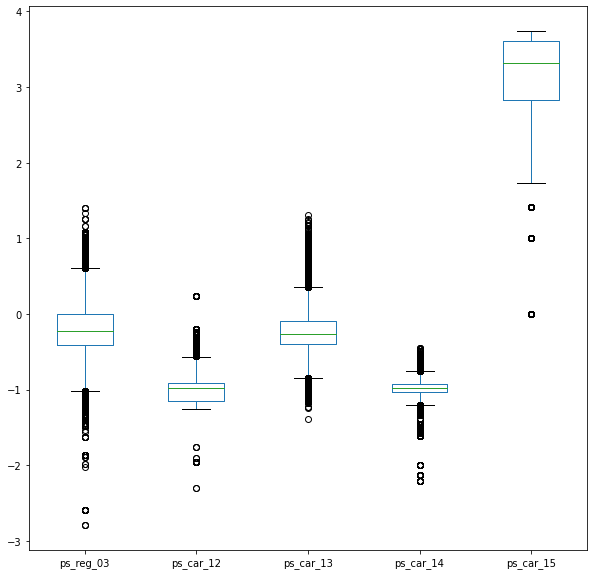

In [243]:
# Plotting bix plot to see the variation in the means of th features
f,ax=plt.subplots(figsize=(10,10))
df_data_w_o_OHE[con_cols_flt_ratio].plot(kind='box', ax=ax)
plt.show()

In [244]:
# For OHE Dataset
df_data_w_OHE_otl,index=rem_outlier(copy.deepcopy(df_data_w_OHE),con_cols_flt_ratio)

IQR:  0.40554323966035455
IQR:  0.23500181467611403
IQR:  0.30062550213065786
IQR:  0.11260655972307321
IQR:  0.7771241510000002


In [245]:
print("No.of Samples after removal of outlier : ", df_data_w_OHE_otl.shape[0])
print("Total indexes removed which are corresponsing to 0 Class : ", len(index))

No.of Samples after removal of outlier :  513658
Total indexes removed which are corresponsing to 0 Class :  80791


In [246]:
# For without OHE Dataset
df_data_w_o_OHE_otl,index_1=rem_outlier(copy.deepcopy(df_data_w_o_OHE),con_cols_flt_ratio)

IQR:  0.40554323966035455
IQR:  0.23500181467611403
IQR:  0.30062550213065786
IQR:  0.11260655972307321
IQR:  0.7771241510000002


In [247]:
print("No.of Samples after removal of outlier : ", df_data_w_o_OHE_otl.shape[0])
print("Total indexes removed which are corresponsing to 0 Class : ", len(index_1))

No.of Samples after removal of outlier :  513658
Total indexes removed which are corresponsing to 0 Class :  80791


# Splitting the Data into train and test dataset

## With OHE Data

In [248]:
from sklearn.model_selection import train_test_split

In [249]:
X=df_data_w_OHE_otl.drop('target',axis=1)
y=df_data_w_OHE_otl.target
X_train_w_ohe,X_test_w_ohe,y_train_w_ohe,y_test_w_ohe=train_test_split(X,y,test_size=0.2,random_state=42)

## Without OHE Data

In [250]:
X=df_data_w_o_OHE_otl.drop('target',axis=1)
y=df_data_w_o_OHE_otl.target
X_train_w_o_ohe,X_test_w_o_ohe,y_train_w_o_ohe,y_test_w_o_ohe=train_test_split(X,y,test_size=0.2,random_state=42)

## Data Transformation  - Standardization and Normalization

In [251]:
# Creating list of columns
con_cols_flt_ratio=df_con_ratio_sk.columns.tolist()
con_cols_int=df_con_int.columns.tolist()

In [252]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [253]:
standard_scl=StandardScaler()
minmax_scl=MinMaxScaler()

## With OHE Data following steps will be carried out

    1. Standardization of Ratio Variables
    2. Normalization of Ordinal Variables

In [254]:
standard_scl.fit(X_train_w_ohe[con_cols_flt_ratio])
X_train_w_ohe[con_cols_flt_ratio]=standard_scl.transform(X_train_w_ohe[con_cols_flt_ratio])

In [255]:
X_test_w_ohe[con_cols_flt_ratio]=standard_scl.transform(X_test_w_ohe[con_cols_flt_ratio])

In [256]:
minmax_scl.fit(X_train_w_ohe[con_cols_int])
X_train_w_ohe[con_cols_int]=minmax_scl.transform(X_train_w_ohe[con_cols_int])
X_test_w_ohe[con_cols_int]=minmax_scl.transform(X_test_w_ohe[con_cols_int])

## Without OHE Data following steps will be carried out

    1. Standardization of Ratio Variables
    2. Normalization of Ordinal Variables
    3. Normalization of Categorical features - as OHE is not carried out in this


In [257]:
X_train_w_o_ohe[con_cols_flt_ratio]=standard_scl.transform(X_train_w_o_ohe[con_cols_flt_ratio])
X_test_w_o_ohe[con_cols_flt_ratio]=standard_scl.transform(X_test_w_o_ohe[con_cols_flt_ratio])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [258]:
X_train_w_o_ohe[con_cols_int]=minmax_scl.transform(X_train_w_o_ohe[con_cols_int])
X_test_w_o_ohe[con_cols_int]=minmax_scl.transform(X_test_w_o_ohe[con_cols_int])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [259]:
cat_cols=df_cat_w_o_OHE.columns.tolist()
minmax_scl=MinMaxScaler()

In [260]:
minmax_scl.fit(X_train_w_o_ohe[cat_cols])
X_train_w_o_ohe[cat_cols]=minmax_scl.transform(X_train_w_o_ohe[cat_cols])
X_test_w_o_ohe[cat_cols]=minmax_scl.transform(X_test_w_o_ohe[cat_cols])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

# Application of SMOTE on Training Data

## Data Augmentation for Handling Imbalanced Dataset

In [261]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [262]:
def smt(X_tr,y_tr,op=1):
    over = SMOTE(sampling_strategy=0.14) #Over Sampling of Minority Class
    under = RandomUnderSampler(sampling_strategy=0.5) # Undersampling of Majority class
    steps = [('o', over), ('u', under)]
    steps_1=[('o', over)]
    if op==1:
        pipeline = Pipeline(steps=steps_1)
    else:
        pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X_tr,y_tr)
    return X,y

## With OHE

In [263]:
# Current Imbalnce Situation as percentage
y_train_w_ohe.value_counts(normalize=True)

0    0.957805
1    0.042195
Name: target, dtype: float64

In [264]:
X_train_SMT_w_ohe=copy.deepcopy(X_train_w_ohe)
y_train_SMT_w_ohe=copy.deepcopy(y_train_w_ohe)

In [265]:
# Applying the SMOTE on the training data set - oversampling
X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o = smt(X_train_SMT_w_ohe, y_train_SMT_w_ohe,1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [266]:
# Applying the SMOTE on the training data set - oversampling
X_train_SMT_w_ohe_ou, y_train_SMT_w_ohe_ou = smt(X_train_SMT_w_ohe, y_train_SMT_w_ohe,2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [267]:
# Current Imbalnce Situation as percentage - Over Sampling
y_train_SMT_w_ohe.value_counts(normalize=True)

0    0.957805
1    0.042195
Name: target, dtype: float64

In [269]:
type(y_train_SMT_w_ohe)

pandas.core.series.Series

In [270]:
# Current Imbalnce Situation as percentage - Over and Under Sampling
pd.Series(y_train_SMT_w_ohe_ou).value_counts(normalize=True)

0    0.666667
1    0.333333
dtype: float64

## Without OHE

In [271]:
# Current Imbalnce Situation as percentage
y_train_w_o_ohe.value_counts(normalize=True)

0    0.957805
1    0.042195
Name: target, dtype: float64

In [272]:
X_train_SMT_w_o_ohe=copy.deepcopy(X_train_w_o_ohe)
y_train_SMT_w_o_ohe=copy.deepcopy(y_train_w_o_ohe)

In [273]:
# Applying the SMOTE on the training data set - oversampling
X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o = smt(X_train_SMT_w_o_ohe,y_train_SMT_w_o_ohe,1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [274]:
# Applying the SMOTE on the training data set - oversampling
X_train_SMT_w_o_ohe_ou, y_train_SMT_w_o_ohe_ou = smt(X_train_SMT_w_o_ohe,y_train_SMT_w_o_ohe,2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [275]:
print("No. of Training records before adjusting minority class to 12% : ",y_train_w_o_ohe.shape[0])
print("No. of Training records after adjusting minority class to 12% : ",y_train_SMT_w_o_ohe_o.shape[0])
print("Increase in records : ",y_train_SMT_w_o_ohe_o.shape[0] - y_train_w_o_ohe.shape[0])

No. of Training records before adjusting minority class to 12% :  410926
No. of Training records after adjusting minority class to 12% :  448689
Increase in records :  37763


# Training Models

## Logistic Regression

In [276]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [277]:
def lr_fit(X_tr,y_tr,X_tst,y_tst,cl_wt=None,max_iter=300):
    lr_model=LogisticRegression(solver='lbfgs',max_iter=max_iter, penalty='l2', C=0.01,class_weight=cl_wt)
    lr_model.fit(X_tr,y_tr)
    y_pred_lr=lr_model.predict(X_tst)
    f1_sc=np.round(f1_score(y_tst,y_pred_lr),4)
    return y_pred_lr,f1_sc

## With OHE - 12% Balanced Data 

In [278]:
#class_weight= None
y_pred,f1_sc=lr_fit(X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe,y_test_w_ohe)
print("F1 Score : ", f1_sc)

F1 Score :  0.0718


In [279]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98     98449
     class 1       0.46      0.04      0.07      4283

    accuracy                           0.96    102732
   macro avg       0.71      0.52      0.53    102732
weighted avg       0.94      0.96      0.94    102732



## Inference

    1. F1 is low, reason is the type of data 1) Imbalanced, 2) Variance of data between the 2 classes is low
    2. Precision for Class 1 - 45%
    3. Re-Call for Class 1 - 7%    
    4. The lower F1 score and Lower recall values shows us the impact of imbalance dataset while fitting the data

In [280]:
#class_weight= 'balanced'
y_pred,f1_sc=lr_fit(X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe,y_test_w_ohe,'balanced')
print("F1 Score : ", f1_sc)

F1 Score :  0.1155


In [281]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.97      0.66      0.79     98449
     class 1       0.06      0.53      0.12      4283

    accuracy                           0.66    102732
   macro avg       0.52      0.60      0.45    102732
weighted avg       0.93      0.66      0.76    102732



## Inference

    1. By provided the class weight balanced, weight proportional to the inverse of ratio between the class is applied.
    2. Precision of Class 1 - 10% (Deproved)
    3. Re-Call of Class 1 - 32% (Improved)
    4. Accuracy - 84%

## Without OHE - 12% Balanced Data

In [282]:
#class_weight= None
y_pred,f1_sc=lr_fit(X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o,X_test_w_o_ohe,y_test_w_o_ohe,None,1000)
print("F1 Score : ", f1_sc)

F1 Score :  0.0367


In [283]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_o_ohe, y_pred, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98     98449
     class 1       0.64      0.02      0.04      4283

    accuracy                           0.96    102732
   macro avg       0.80      0.51      0.51    102732
weighted avg       0.95      0.96      0.94    102732



In [284]:
#class_weight= Balanced
y_pred,f1_sc=lr_fit(X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o,X_test_w_o_ohe,y_test_w_o_ohe,'balanced',1000)
print("F1 Score : ", f1_sc)

F1 Score :  0.1134


In [285]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_o_ohe, y_pred, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.97      0.66      0.78     98449
     class 1       0.06      0.53      0.11      4283

    accuracy                           0.65    102732
   macro avg       0.52      0.60      0.45    102732
weighted avg       0.93      0.65      0.76    102732



## Inference


    1. From the above 2 Scenario we can see that, fitting the model with class weight balanced, improves the Re-Call Value.

## With Over - Under Sampled Data - With OHE

In [335]:
#class_weight= 'balanced'
y_pred_1,f1_sc=lr_fit(X_train_SMT_w_ohe_ou, y_train_SMT_w_ohe_ou,X_test_w_ohe,y_test_w_ohe,'balanced')
print("F1 Score : ", f1_sc)

F1 Score :  0.1164


In [336]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred_1, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.97      0.66      0.79     98449
     class 1       0.07      0.54      0.12      4283

    accuracy                           0.66    102732
   macro avg       0.52      0.60      0.45    102732
weighted avg       0.93      0.66      0.76    102732



In [337]:
#class_weight=None
y_pred_2,f1_sc=lr_fit(X_train_SMT_w_ohe_ou, y_train_SMT_w_ohe_ou,X_test_w_ohe,y_test_w_ohe)
print("F1 Score : ", f1_sc)

F1 Score :  0.1579


In [338]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred_2, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      0.95      0.96     98449
     class 1       0.14      0.18      0.16      4283

    accuracy                           0.92    102732
   macro avg       0.55      0.57      0.56    102732
weighted avg       0.93      0.92      0.92    102732



# Linear SVC

In [290]:
from sklearn.svm import LinearSVC

In [291]:
def svc_fit(X_tr,y_tr,X_tst,y_tst,cl_wt=None,max_iter=1000,dual=True):
    model=LinearSVC(C=0.01,class_weight=cl_wt,max_iter=max_iter,dual=dual)
    model.fit(X_tr,y_tr)
    y_pred_lr=model.predict(X_tst)
    f1_sc=np.round(f1_score(y_tst,y_pred_lr),4)
    return y_pred_lr,f1_sc

## With OHE - 12% Balanced Data 

In [292]:
# Class Weight - None, Max_iter-1000, dual=True
y_pred_1,f1_sc=svc_fit(X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe,y_test_w_ohe)
print("F1 Score : ", f1_sc)

F1 Score :  0.0689


In [293]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred_1, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98     98449
     class 1       0.44      0.04      0.07      4283

    accuracy                           0.96    102732
   macro avg       0.70      0.52      0.52    102732
weighted avg       0.94      0.96      0.94    102732



In [294]:
# Class Weight - balanced, Max_iter-1000, dual=True
y_pred_2,f1_sc=svc_fit(X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe,y_test_w_ohe,'balanced')
print("F1 Score : ", f1_sc)

F1 Score :  0.1158


In [295]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred_2, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.97      0.67      0.79     98449
     class 1       0.06      0.53      0.12      4283

    accuracy                           0.66    102732
   macro avg       0.52      0.60      0.45    102732
weighted avg       0.93      0.66      0.76    102732



In [296]:
# Class Weight - balanced, Max_iter-1000, dual=False
y_pred_3,f1_sc=svc_fit(X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe,y_test_w_ohe,'balanced',1000,False)
print("F1 Score : ", f1_sc)

F1 Score :  0.1158


In [297]:
# Class Weight - balanced, Max_iter-1000, dual=False
y_pred_4,f1_sc=svc_fit(X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe,y_test_w_ohe,'balanced',1500,False)
print("F1 Score : ", f1_sc)

F1 Score :  0.1158


In [298]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred_4, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.97      0.67      0.79     98449
     class 1       0.06      0.53      0.12      4283

    accuracy                           0.66    102732
   macro avg       0.52      0.60      0.45    102732
weighted avg       0.93      0.66      0.76    102732



## Inference - Linear SVC

    1. Increase in F1 score noticed from 10.41% to 15.95%, by assigning class wt as balanced.
    2. Re-Call value increased from 7% to 27%

## Without OHE - 12% Balanced Data

In [299]:
# Class Weight - None, Max_iter-1000, dual=True
y_pred_1,f1_sc=svc_fit(X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o,X_test_w_o_ohe,y_test_w_o_ohe)
print("F1 Score : ", f1_sc)

F1 Score :  0.0079


In [300]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_o_ohe, y_pred_1, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98     98449
     class 1       1.00      0.00      0.01      4283

    accuracy                           0.96    102732
   macro avg       0.98      0.50      0.49    102732
weighted avg       0.96      0.96      0.94    102732



In [301]:
# Class Weight - balanced, Max_iter-1000, dual=True
y_pred_2,f1_sc=svc_fit(X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o,X_test_w_o_ohe,y_test_w_o_ohe,'balanced')
print("F1 Score : ", f1_sc)

F1 Score :  0.1144


In [302]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_o_ohe, y_pred_2, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.97      0.66      0.79     98449
     class 1       0.06      0.53      0.11      4283

    accuracy                           0.66    102732
   macro avg       0.52      0.60      0.45    102732
weighted avg       0.93      0.66      0.76    102732



## Inference

    1. Subtantial increase in F1 score observed by prividing class weight to balanced - 4.8% to 15%
    2. Re-Call for Class 1 increased from 2% to 28%
    3. Accuracy decreased from 96% to 86%

# XG Boost

In [303]:
from xgboost import XGBClassifier

In [304]:
def xg_fit(X_tr,y_tr,X_tst,y_tst):
    model = XGBClassifier( use_label_encoder=False,eval_metric='logloss')
    model.fit(X_tr,y_tr)
    y_pred_lr=model.predict(X_tst)
    f1_sc=np.round(f1_score(y_tst,y_pred_lr),4)
    return y_pred_lr,f1_sc

## With OHE - 12% Balanced Data

In [306]:
y_test_w_ohe

209488    0
320355    0
458715    0
65214     0
136281    0
         ..
146791    0
285895    0
457783    0
539459    0
269122    0
Name: target, Length: 102732, dtype: int64

In [310]:
type(X_test_w_ohe)

pandas.core.frame.DataFrame

In [311]:
y_pred_1,f1_sc=xg_fit(X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe.to_numpy(),y_test_w_ohe)
print("F1 Score : ", f1_sc)

F1 Score :  0.2568


In [312]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred_1, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98     98449
     class 1       1.00      0.15      0.26      4283

    accuracy                           0.96    102732
   macro avg       0.98      0.57      0.62    102732
weighted avg       0.97      0.96      0.95    102732



## Without OHE - 12% Balanced Data

In [313]:
y_pred_2,f1_sc=xg_fit(X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o,X_test_w_o_ohe.to_numpy(),y_test_w_o_ohe)
print("F1 Score : ", f1_sc)

F1 Score :  0.2575


In [314]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_o_ohe, y_pred_2, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98     98449
     class 1       1.00      0.15      0.26      4283

    accuracy                           0.96    102732
   macro avg       0.98      0.57      0.62    102732
weighted avg       0.97      0.96      0.95    102732



# ADABOOST

In [315]:
from sklearn.ensemble import AdaBoostClassifier

In [316]:
def ada_fit(X_tr,y_tr,X_tst,y_tst):
    model = AdaBoostClassifier()
    model.fit(X_tr,y_tr)
    y_pred_lr=model.predict(X_tst)
    f1_sc=np.round(f1_score(y_tst,y_pred_lr),4)
    return y_pred_lr,f1_sc

## With OHE - 12% Balanced Data

In [317]:
y_pred_1,f1_sc=ada_fit(X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe,y_test_w_ohe)
print("F1 Score : ", f1_sc)

F1 Score :  0.2589


In [318]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred_1, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98     98449
     class 1       1.00      0.15      0.26      4283

    accuracy                           0.96    102732
   macro avg       0.98      0.57      0.62    102732
weighted avg       0.97      0.96      0.95    102732



## Without OHE - 12% Balanced Data

In [319]:
y_pred_2,f1_sc=ada_fit(X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o,X_test_w_o_ohe,y_test_w_o_ohe)
print("F1 Score : ", f1_sc)

F1 Score :  0.2585


In [320]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_o_ohe, y_pred_2, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98     98449
     class 1       0.97      0.15      0.26      4283

    accuracy                           0.96    102732
   macro avg       0.97      0.57      0.62    102732
weighted avg       0.96      0.96      0.95    102732



## Inference 

    1. If not missing a positive sample is top priority - which is Re-Call for Class 1 - Logistic Regression provides the best result of 32%.
    2. If not marking negative sample as positive is top priority - which is the precision for Class 1, XG Boost provides the best result of 100%
    3. No significant imporvement in F1 score obtained by Adaboost compared to XGBoost
    4. Both with Encoding of categorical variables and with encoding the F1 score are comparable.Not significant imporvement is observed.

# Comparison Summary Report of the performance of the above models

## LogReg Linear SVC XGBoost ADABOOST

    1. With 12% Balanced Data
    2. With over and under Sampled Data
    
     All the above action will be carried out for OHE data and Non-OHE Data set
     The impact of class wt balance shall be checked for Logistic Regression and Linear SVC

In [321]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [322]:
import warnings
warnings.filterwarnings("ignore")

In [323]:
Summ_dict=dict()

In [324]:
def gen_sum(sum_dict,X_tr,y_tr,X_tst,y_tst,dt_type,SMT_opt,mod,cl_wt=None):
    
    SMT='ov'
    bal='nb'
     
    if SMT_opt==2: SMT='ov_udr'
    if cl_wt!=None: bal='b'      
        
    if mod==1:
        model='log_reg'
        y_pred,f1_sc=lr_fit(X_tr,y_tr,X_tst,y_tst,cl_wt)
    if mod==2:
        model='svc'
        y_pred,f1_sc=svc_fit(X_tr,y_tr,X_tst,y_tst,cl_wt)
    if mod==3:
        model='xgb'
        bal='nb'
        y_pred,f1_sc=xg_fit(X_tr,y_tr,X_tst,y_tst)
    if mod==4:
        model='adabst'
        bal='nb'
        y_pred,f1_sc=ada_fit(X_tr,y_tr,X_tst,y_tst)  
            
    
    idx=model+'_'+dt_type+'_'+SMT+'_'+bal
    f1_sc=f1_sc*100
    ac_sc=np.round(accuracy_score(y_tst,y_pred),4)*100
    pre_sc=np.round(precision_score(y_tst,y_pred),4)*100
    rec_sc=np.round(recall_score(y_tst,y_pred),4)*100
   
    
        
        
    sum_dict[idx]={'Model':model,'Dtype':dt_type,'Bal_check':bal,'SMT_aug':SMT,'f1_sc':f1_sc,'Accuracy':ac_sc,'Precision':pre_sc,
                     "Re-call":rec_sc}

    
    return sum_dict

In [326]:
Summ_dict=dict()
for i in range(1,5):
      
    #With OHE - 12%
    dtype='ohe'
    smt=1
    mod=i
    final_dict=gen_sum(Summ_dict,X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe.to_numpy(),y_test_w_ohe,dtype,smt,mod)
    final_dict=gen_sum(final_dict,X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o,X_test_w_ohe.to_numpy(),y_test_w_ohe,dtype,smt,mod,'balanced')
    
    #Without OHE - 12%
    dtype='wo_ohe'
    smt=1
    mod=i
    final_dict=gen_sum(final_dict,X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o,X_test_w_o_ohe.to_numpy(),y_test_w_o_ohe,dtype,smt,mod)
    final_dict=gen_sum(final_dict,X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o,X_test_w_o_ohe.to_numpy(),y_test_w_o_ohe,dtype,smt,mod,'balanced')
    
    #With OHE - Ovr_Under
    dtype='ohe'
    smt=2
    mod=i
    final_dict=gen_sum(final_dict,X_train_SMT_w_ohe_ou, y_train_SMT_w_ohe_ou,X_test_w_ohe.to_numpy(),y_test_w_ohe,dtype,smt,mod)
    final_dict=gen_sum(final_dict,X_train_SMT_w_ohe_ou, y_train_SMT_w_ohe_ou,X_test_w_ohe.to_numpy(),y_test_w_ohe,dtype,smt,mod,'balanced')
    
    #Without OHE - Ovr_Under
    dtype='wo_ohe'
    smt=2
    mod=i
    final_dict=gen_sum(final_dict,X_train_SMT_w_o_ohe_ou, y_train_SMT_w_o_ohe_ou,X_test_w_o_ohe.to_numpy(),y_test_w_o_ohe,dtype,smt,mod)
    final_dict=gen_sum(final_dict,X_train_SMT_w_o_ohe_ou, y_train_SMT_w_o_ohe_ou,X_test_w_o_ohe.to_numpy(),y_test_w_o_ohe,dtype,smt,mod,'balanced')

    print("Completed Execution for Model No : ", i)

Completed Execution for Model No :  1
Completed Execution for Model No :  2
Completed Execution for Model No :  3
Completed Execution for Model No :  4


In [327]:
df_sum=pd.DataFrame(final_dict).T

# Performance Summary

In [328]:
df_sum

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
log_reg_ohe_ov_nb,log_reg,ohe,nb,ov,7.18,95.8,45.5,3.9
log_reg_ohe_ov_b,log_reg,ohe,b,ov,11.55,65.92,6.48,53.4
log_reg_wo_ohe_ov_nb,log_reg,wo_ohe,nb,ov,3.67,95.86,63.78,1.89
log_reg_wo_ohe_ov_b,log_reg,wo_ohe,b,ov,11.34,65.28,6.35,53.26
log_reg_ohe_ov_udr_nb,log_reg,ohe,nb,ov_udr,15.79,91.9,13.94,18.21
log_reg_ohe_ov_udr_b,log_reg,ohe,b,ov_udr,11.64,65.92,6.52,53.84
log_reg_wo_ohe_ov_udr_nb,log_reg,wo_ohe,nb,ov_udr,14.19,91.64,12.41,16.58
log_reg_wo_ohe_ov_udr_b,log_reg,wo_ohe,b,ov_udr,11.37,65.31,6.36,53.37
svc_ohe_ov_nb,svc,ohe,nb,ov,6.89,95.79,43.96,3.74
svc_ohe_ov_b,svc,ohe,b,ov,11.58,66.2,6.5,53.09


## Performance of Logistics Regression - with various data augmentation 

In [329]:
df_lr_perf=df_sum[df_sum.Model=='log_reg'].sort_values('Re-call',ascending=False)
df_lr_perf

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
log_reg_ohe_ov_udr_b,log_reg,ohe,b,ov_udr,11.64,65.92,6.52,53.84
log_reg_ohe_ov_b,log_reg,ohe,b,ov,11.55,65.92,6.48,53.4
log_reg_wo_ohe_ov_udr_b,log_reg,wo_ohe,b,ov_udr,11.37,65.31,6.36,53.37
log_reg_wo_ohe_ov_b,log_reg,wo_ohe,b,ov,11.34,65.28,6.35,53.26
log_reg_ohe_ov_udr_nb,log_reg,ohe,nb,ov_udr,15.79,91.9,13.94,18.21
log_reg_wo_ohe_ov_udr_nb,log_reg,wo_ohe,nb,ov_udr,14.19,91.64,12.41,16.58
log_reg_ohe_ov_nb,log_reg,ohe,nb,ov,7.18,95.8,45.5,3.9
log_reg_wo_ohe_ov_nb,log_reg,wo_ohe,nb,ov,3.67,95.86,63.78,1.89


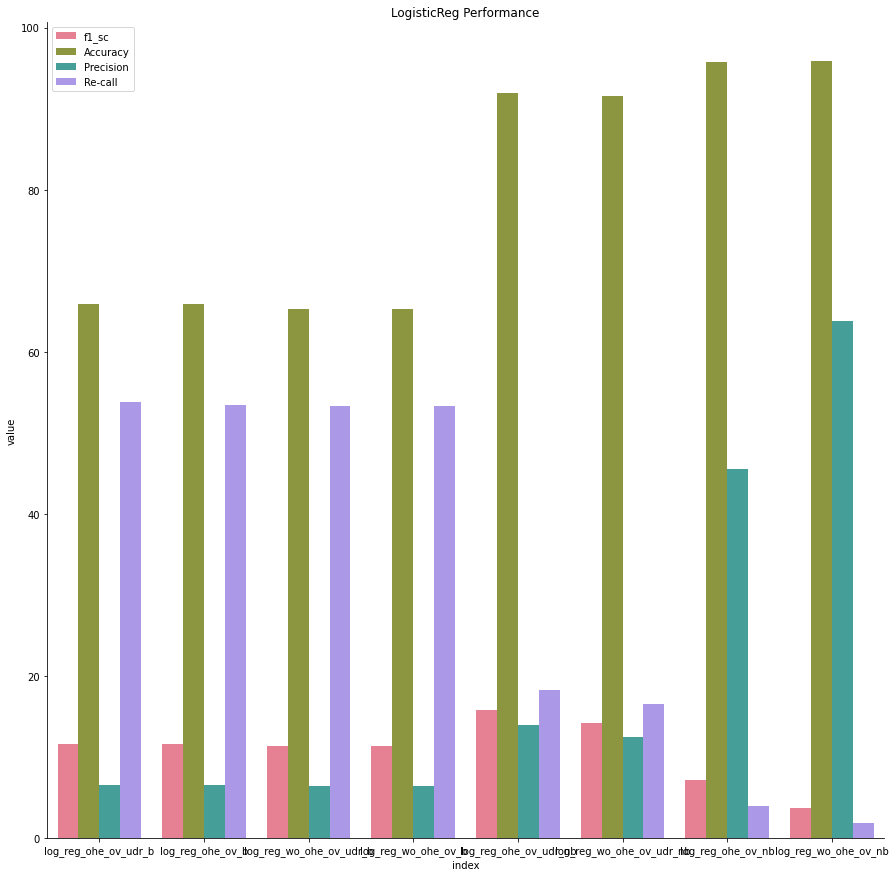

In [330]:
df_lr_perf=df_sum[df_sum.Model=='log_reg'].sort_values('Re-call',ascending=False).reset_index()
fig, ax1 = plt.subplots(figsize=(15, 15))
tidy = df_lr_perf.melt(id_vars='index', value_vars=['f1_sc','Accuracy','Precision','Re-call'])
sns.barplot(x='index', y='value', hue='variable', data=tidy, ax=ax1,palette="husl")
plt.title("LogisticReg Performance")
plt.legend(loc='best')
sns.despine(fig)

## Performance of Linear SVC Classifier - with various data augmentation 

In [331]:
df_svc_perf=df_sum[df_sum.Model=='svc'].sort_values('Re-call',ascending=False)
df_svc_perf

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
svc_ohe_ov_udr_b,svc,ohe,b,ov_udr,11.61,66.15,6.51,53.33
svc_wo_ohe_ov_udr_b,svc,wo_ohe,b,ov_udr,11.42,65.66,6.4,53.12
svc_ohe_ov_b,svc,ohe,b,ov,11.58,66.2,6.5,53.09
svc_wo_ohe_ov_b,svc,wo_ohe,b,ov,11.44,65.74,6.41,53.05
svc_ohe_ov_udr_nb,svc,ohe,nb,ov_udr,15.98,92.22,14.54,17.74
svc_wo_ohe_ov_udr_nb,svc,wo_ohe,nb,ov_udr,14.2,91.94,12.77,15.99
svc_ohe_ov_nb,svc,ohe,nb,ov,6.89,95.79,43.96,3.74
svc_wo_ohe_ov_nb,svc,wo_ohe,nb,ov,0.79,95.85,100,0.4


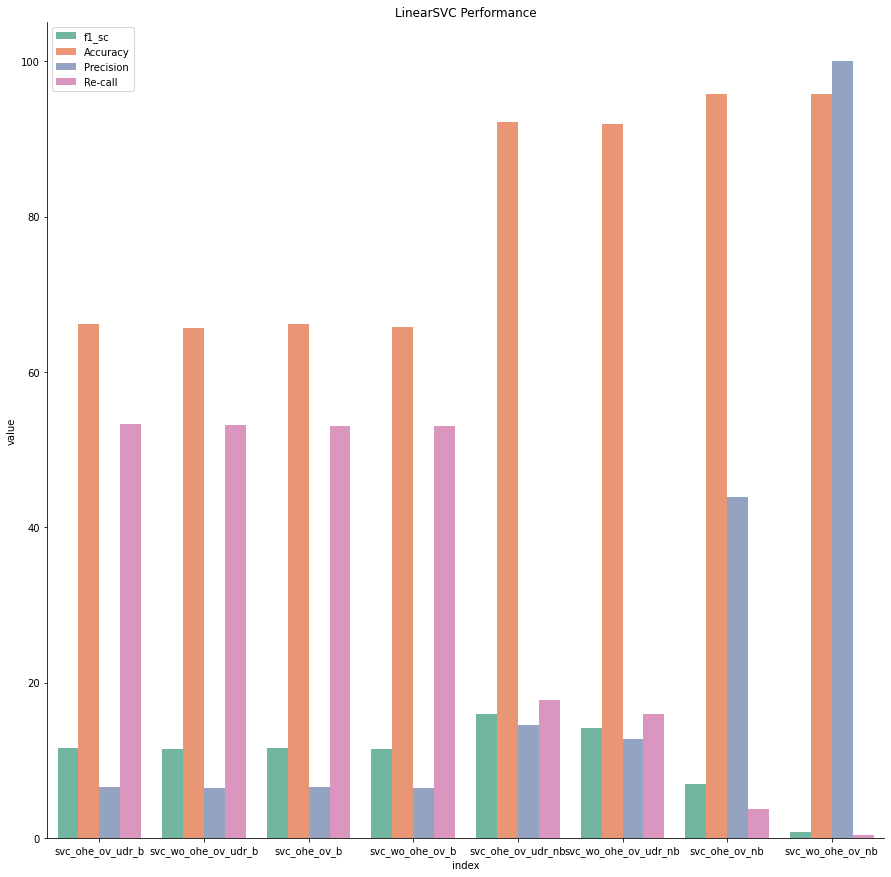

In [342]:
df_svc_perf=df_sum[df_sum.Model=='svc'].sort_values('Re-call',ascending=False).reset_index()
fig, ax1 = plt.subplots(figsize=(15, 15))
tidy = df_svc_perf.melt(id_vars='index', value_vars=['f1_sc','Accuracy','Precision','Re-call'])
sns.barplot(x='index', y='value', hue='variable', data=tidy, ax=ax1,palette="Set2")
plt.title("LinearSVC Performance")
plt.legend(loc='best')
sns.despine(fig)

In [341]:
tidy

,index,variable,value


## Performance of XGboost Classifier - with various data augmentation 

In [343]:
df_sum['Model']

log_reg_ohe_ov_nb           log_reg
log_reg_ohe_ov_b            log_reg
log_reg_wo_ohe_ov_nb        log_reg
log_reg_wo_ohe_ov_b         log_reg
log_reg_ohe_ov_udr_nb       log_reg
log_reg_ohe_ov_udr_b        log_reg
log_reg_wo_ohe_ov_udr_nb    log_reg
log_reg_wo_ohe_ov_udr_b     log_reg
svc_ohe_ov_nb                   svc
svc_ohe_ov_b                    svc
svc_wo_ohe_ov_nb                svc
svc_wo_ohe_ov_b                 svc
svc_ohe_ov_udr_nb               svc
svc_ohe_ov_udr_b                svc
svc_wo_ohe_ov_udr_nb            svc
svc_wo_ohe_ov_udr_b             svc
xgb_ohe_ov_nb                   xgb
xgb_wo_ohe_ov_nb                xgb
xgb_ohe_ov_udr_nb               xgb
xgb_wo_ohe_ov_udr_nb            xgb
adabst_ohe_ov_nb             adabst
adabst_wo_ohe_ov_nb          adabst
adabst_ohe_ov_udr_nb         adabst
adabst_wo_ohe_ov_udr_nb      adabst
Name: Model, dtype: object

In [344]:
df_xgb_perf=df_sum[df_sum.Model=='xgb'].sort_values('Re-call',ascending=False)
df_xgb_perf

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
xgb_ohe_ov_udr_nb,xgb,ohe,nb,ov_udr,26.03,96.45,99.84,14.97
xgb_wo_ohe_ov_udr_nb,xgb,wo_ohe,nb,ov_udr,26.02,96.45,99.53,14.97
xgb_wo_ohe_ov_nb,xgb,wo_ohe,nb,ov,25.75,96.45,100,14.78
xgb_ohe_ov_nb,xgb,ohe,nb,ov,25.68,96.45,100,14.73


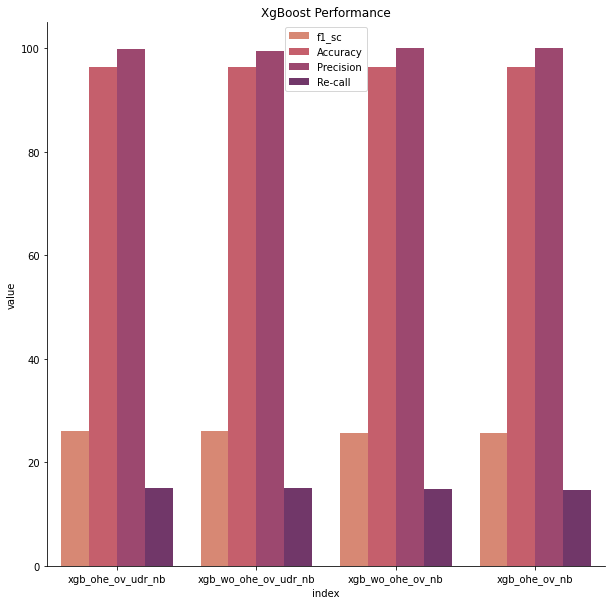

In [345]:
df_xgb_perf=df_sum[df_sum.Model=='xgb'].sort_values('Re-call',ascending=False).reset_index()
fig, ax1 = plt.subplots(figsize=(10,10))
tidy = df_xgb_perf.melt(id_vars='index', value_vars=['f1_sc','Accuracy','Precision','Re-call'])
sns.barplot(x='index', y='value', hue='variable', data=tidy, ax=ax1,palette="flare")
plt.title("XgBoost Performance")
plt.legend(loc='best')
sns.despine(fig)

## Performance of Adaboost Classifier - with various data augmentation 

In [346]:
df_ada_perf=df_sum[df_sum.Model=='adabst'].sort_values('Re-call',ascending=False)
df_ada_perf

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
adabst_wo_ohe_ov_udr_nb,adabst,wo_ohe,nb,ov_udr,23.57,95.45,39.27,16.83
adabst_wo_ohe_ov_nb,adabst,wo_ohe,nb,ov,25.85,96.43,96.67,14.92
adabst_ohe_ov_udr_nb,adabst,ohe,nb,ov_udr,25.82,96.43,96.96,14.9
adabst_ohe_ov_nb,adabst,ohe,nb,ov,25.89,96.45,100,14.87


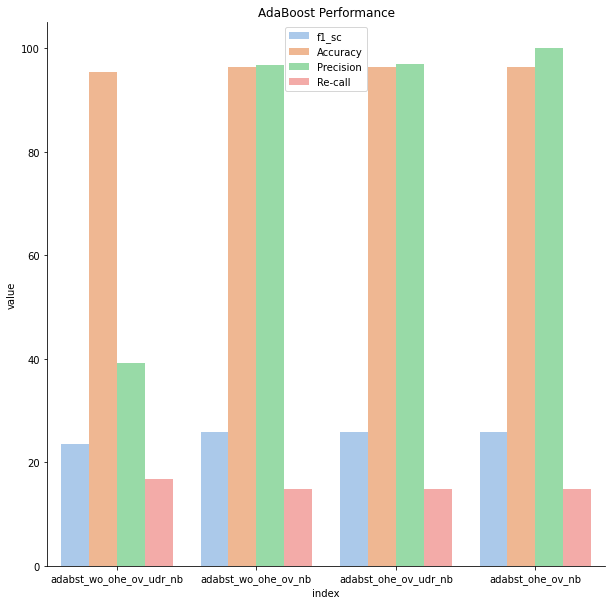

In [347]:
df_ada_perf=df_sum[df_sum.Model=='adabst'].sort_values('Re-call',ascending=False).reset_index()
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = df_ada_perf.melt(id_vars='index', value_vars=['f1_sc','Accuracy','Precision','Re-call'])
sns.barplot(x='index', y='value', hue='variable', data=tidy, ax=ax1,palette="pastel")
plt.title("AdaBoost Performance")
plt.legend(loc='best')
sns.despine(fig)

In [348]:
df_sum.sort_values('f1_sc',ascending=False)[0:5]

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
xgb_ohe_ov_udr_nb,xgb,ohe,nb,ov_udr,26.03,96.45,99.84,14.97
xgb_wo_ohe_ov_udr_nb,xgb,wo_ohe,nb,ov_udr,26.02,96.45,99.53,14.97
adabst_ohe_ov_nb,adabst,ohe,nb,ov,25.89,96.45,100,14.87
adabst_wo_ohe_ov_nb,adabst,wo_ohe,nb,ov,25.85,96.43,96.67,14.92
adabst_ohe_ov_udr_nb,adabst,ohe,nb,ov_udr,25.82,96.43,96.96,14.9


## Inference - F1 Score

    1. Highest F1 Score is provided by xgboost model - around 35%
    2. With Xgboost - data augmented with one hot encoding and without or 12% over sampling and mix of over and under sampling is similar in Xgboost


In [349]:
df_sum.sort_values('Precision',ascending=False)[0:5]

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
xgb_ohe_ov_nb,xgb,ohe,nb,ov,25.68,96.45,100,14.73
adabst_ohe_ov_nb,adabst,ohe,nb,ov,25.89,96.45,100,14.87
xgb_wo_ohe_ov_nb,xgb,wo_ohe,nb,ov,25.75,96.45,100,14.78
svc_wo_ohe_ov_nb,svc,wo_ohe,nb,ov,0.79,95.85,100,0.4
xgb_ohe_ov_udr_nb,xgb,ohe,nb,ov_udr,26.03,96.45,99.84,14.97


## Inference - Precision

    1. Xgboost provides the model with highest precision
    2. To be noted here, out of 5, the first 4 cases represents data prepared by OHE of categorical variables.
    3  Out of 5, in 4 cases are SMOTE applied is only over sampling 12% 

In [350]:
df_sum.sort_values('Re-call',ascending=False)[0:5]

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
log_reg_ohe_ov_udr_b,log_reg,ohe,b,ov_udr,11.64,65.92,6.52,53.84
log_reg_ohe_ov_b,log_reg,ohe,b,ov,11.55,65.92,6.48,53.4
log_reg_wo_ohe_ov_udr_b,log_reg,wo_ohe,b,ov_udr,11.37,65.31,6.36,53.37
svc_ohe_ov_udr_b,svc,ohe,b,ov_udr,11.61,66.15,6.51,53.33
log_reg_wo_ohe_ov_b,log_reg,wo_ohe,b,ov,11.34,65.28,6.35,53.26


## Inference - Recall

    1. Logistic Regression is giving the better result as far as Recall is concerned - 50%
    2. Data prepared without one hot encoding of categorical data provides better recall values.
    3. Data augmented with mix of over and under sampling provides the best result.

In [351]:
df_sum.sort_values('Accuracy',ascending=False)[0:5]

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
xgb_ohe_ov_nb,xgb,ohe,nb,ov,25.68,96.45,100,14.73
adabst_ohe_ov_nb,adabst,ohe,nb,ov,25.89,96.45,100,14.87
xgb_wo_ohe_ov_udr_nb,xgb,wo_ohe,nb,ov_udr,26.02,96.45,99.53,14.97
xgb_ohe_ov_udr_nb,xgb,ohe,nb,ov_udr,26.03,96.45,99.84,14.97
xgb_wo_ohe_ov_nb,xgb,wo_ohe,nb,ov,25.75,96.45,100,14.78


## Inference - Accuracy

    1. Accurracy in a highly imbalanced dataset, is not of much importance.
    2. Xgboost provides the best result of 96.55%

# MLP Classifier - SK Learn

## With OHE Data - 12% Balanced

In [352]:
from sklearn.neural_network import MLPClassifier

In [353]:
mlp_class=MLPClassifier(hidden_layer_sizes=(256,256,128,128,64),random_state=1, max_iter=300,early_stopping=True)

In [354]:
mlp_class.fit(X_train_SMT_w_ohe_o, y_train_SMT_w_ohe_o)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(256, 256, 128, 128, 64),
              learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
              max_iter=300, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [355]:
y_pred=mlp_class.predict(X_test_w_ohe)

In [356]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred, target_names=target_names)
print(clf_rep)


              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97     98449
     class 1       0.29      0.14      0.19      4283

    accuracy                           0.95    102732
   macro avg       0.63      0.56      0.58    102732
weighted avg       0.94      0.95      0.94    102732



## Without OHE Data - 12% Balanced

In [357]:
mlp_class_1=MLPClassifier(hidden_layer_sizes=(256,256,128,128,64),random_state=1, max_iter=300,early_stopping=True)

In [358]:
mlp_class_1.fit(X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(256, 256, 128, 128, 64),
              learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
              max_iter=300, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [359]:
y_pred=mlp_class_1.predict(X_test_w_o_ohe)

In [360]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_o_ohe, y_pred, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97     98449
     class 1       0.23      0.14      0.18      4283

    accuracy                           0.94    102732
   macro avg       0.60      0.56      0.57    102732
weighted avg       0.93      0.94      0.94    102732



## With OHE - Over (12%) and Under Sampling (50%)

In [361]:
mlp_class_2=MLPClassifier(hidden_layer_sizes=(256,128,128,64),random_state=1, max_iter=300,early_stopping=True)

In [362]:
mlp_class_2.fit(X_train_SMT_w_ohe_ou, y_train_SMT_w_ohe_ou)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(256, 128, 128, 64), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [363]:
y_pred=mlp_class_2.predict(X_test_w_ohe)

In [364]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_ohe, y_pred, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      0.92      0.94     98449
     class 1       0.10      0.22      0.14      4283

    accuracy                           0.89    102732
   macro avg       0.53      0.57      0.54    102732
weighted avg       0.93      0.89      0.91    102732



## Without OHE - Over (12%) and Under Sampling (50%)

In [365]:
X_train_SMT_w_o_ohe_ou, y_train_SMT_w_o_ohe_ou,X_test_w_o_ohe,y_test_w_o_ohe

(array([[ 0.        ,  0.        ,  0.        , ..., -0.25900165,
         -0.1459827 ,  0.59186237],
        [ 0.        ,  0.        ,  1.        , ..., -0.96936786,
         -0.29039964,  0.29281555],
        [ 0.        ,  0.        ,  1.        , ..., -0.64741943,
         -1.16826657, -0.34922186],
        ...,
        [ 0.        ,  1.        ,  0.        , ...,  1.33192911,
          0.05393772,  1.14747607],
        [ 0.        ,  1.        ,  0.        , ...,  0.21345456,
         -0.21320831, -0.62638453],
        [ 0.        ,  1.        ,  0.        , ...,  2.95843017,
          0.18966316,  0.29281555]]),
 array([0, 0, 0, ..., 1, 1, 1]),
         ps_ind_06_bin  ps_ind_07_bin  ...  ps_car_14  ps_car_15
 209488              0              1  ...   0.310879   0.878688
 320355              1              0  ...   0.151226   1.154677
 458715              1              0  ...  -1.322564  -1.067551
 65214               1              0  ...   0.151226  -0.020163
 136281        

In [366]:
mlp_class_3=MLPClassifier(hidden_layer_sizes=(256,128,128,64),random_state=1, max_iter=300,early_stopping=True)

In [367]:
mlp_class_3.fit(X_train_SMT_w_o_ohe_ou, y_train_SMT_w_o_ohe_ou)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(256, 128, 128, 64), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [368]:
y_pred=mlp_class_3.predict(X_test_w_o_ohe)

In [369]:
target_names = ['class 0', 'class 1']
clf_rep=classification_report(y_test_w_o_ohe, y_pred, target_names=target_names)
print(clf_rep)

              precision    recall  f1-score   support

     class 0       0.96      0.91      0.94     98449
     class 1       0.10      0.22      0.14      4283

    accuracy                           0.88    102732
   macro avg       0.53      0.57      0.54    102732
weighted avg       0.93      0.88      0.90    102732



## Inference  - MLP Classifier

    1. There is no definite way to to choose the right no. of layers other than trial and error.
    2. The layer soze at which we got the best f1 score is (256, 256, 128, 128, 64)

## Updating the Summary Dictionary

In [370]:
final_dict['MLP_ohe_ov_nb']={'Model':'MLP','Dtype':'ohe','Bal_check':'nb','SMT_aug':'ov','f1_sc':29,'Accuracy':96,'Precision':52,
                     "Re-call":20}
final_dict['MLP_wo_ohe_ov_nb']={'Model':'MLP','Dtype':'wo_ohe','Bal_check':'nb','SMT_aug':'ov','f1_sc':26,'Accuracy':95,'Precision':33,
                     "Re-call":22}
final_dict['MLP_ohe_ov_udr_nb']={'Model':'MLP','Dtype':'ohe','Bal_check':'nb','SMT_aug':'ov_udr','f1_sc':25,'Accuracy':94,'Precision':28,
                     "Re-call":23}
final_dict['MLP_wo_ohe_ov_udr_nb']={'Model':'MLP','Dtype':'wo_ohe','Bal_check':'nb','SMT_aug':'ov_udr','f1_sc':18,'Accuracy':90,'Precision':14,
                     "Re-call":26}

In [371]:
df_sum=pd.DataFrame(final_dict).T

In [372]:
df_sum

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
log_reg_ohe_ov_nb,log_reg,ohe,nb,ov,7.18,95.8,45.5,3.9
log_reg_ohe_ov_b,log_reg,ohe,b,ov,11.55,65.92,6.48,53.4
log_reg_wo_ohe_ov_nb,log_reg,wo_ohe,nb,ov,3.67,95.86,63.78,1.89
log_reg_wo_ohe_ov_b,log_reg,wo_ohe,b,ov,11.34,65.28,6.35,53.26
log_reg_ohe_ov_udr_nb,log_reg,ohe,nb,ov_udr,15.79,91.9,13.94,18.21
log_reg_ohe_ov_udr_b,log_reg,ohe,b,ov_udr,11.64,65.92,6.52,53.84
log_reg_wo_ohe_ov_udr_nb,log_reg,wo_ohe,nb,ov_udr,14.19,91.64,12.41,16.58
log_reg_wo_ohe_ov_udr_b,log_reg,wo_ohe,b,ov_udr,11.37,65.31,6.36,53.37
svc_ohe_ov_nb,svc,ohe,nb,ov,6.89,95.79,43.96,3.74
svc_ohe_ov_b,svc,ohe,b,ov,11.58,66.2,6.5,53.09


## Model wise F1-Score Performance

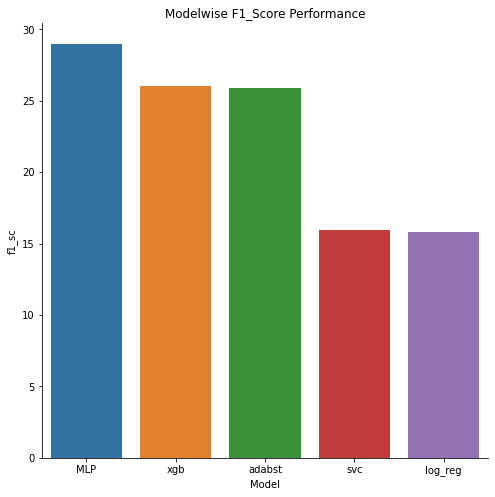

In [373]:
df_f1_sc=df_sum.groupby('Model')['f1_sc'].max().reset_index()
df_f1_sc.sort_values('f1_sc',ascending=False,inplace=True)

fig, ax1 = plt.subplots(figsize=(8, 8))
sns.barplot(x='Model', y='f1_sc',data=df_f1_sc, ax=ax1,palette=None)
plt.title("Modelwise F1_Score Performance")
sns.despine(fig)

## Modelwise Recall Performance

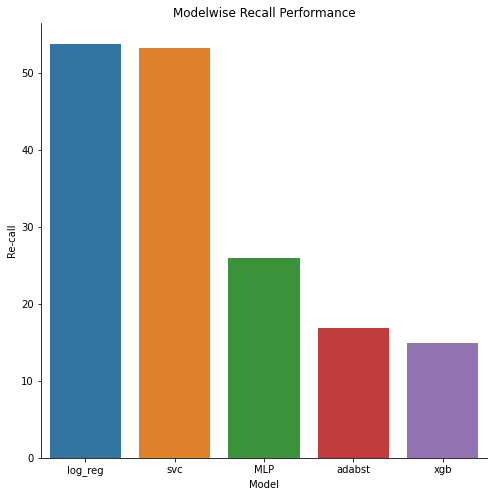

In [374]:
df_rec_sc=df_sum.groupby('Model')['Re-call'].max().reset_index()
df_rec_sc.sort_values('Re-call',ascending=False,inplace=True)

fig, ax1 = plt.subplots(figsize=(8, 8))
sns.barplot(x='Model', y='Re-call',data=df_rec_sc, ax=ax1,palette=None)
plt.title("Modelwise Recall Performance")
sns.despine(fig)

## Modelwise Precision Performance

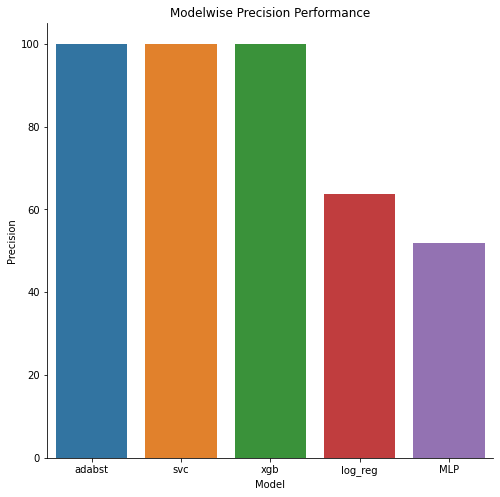

In [375]:
df_pre_sc=df_sum.groupby('Model')['Precision'].max().reset_index()
df_pre_sc.sort_values('Precision',ascending=False,inplace=True)

fig, ax1 = plt.subplots(figsize=(8, 8))
sns.barplot(x='Model', y='Precision',data=df_pre_sc, ax=ax1,palette=None)
plt.title("Modelwise Precision Performance")
sns.despine(fig)

# Thoughts for Further Analysis

    1. As per industry estimate 1% reduction in the claim can boost profit by 10%, so identfying the person who will return for claim and find a way to deny the insurance claim will surely lead to overall profit for the organization.
    2. So the Logistic regression model could be used to predict the same as it is providing the best recall value. But still the chanse of getting it right is 50%.
    3. We can try out some ensemble to capture the prrdicting probabilities of the individual models and make a prediction with a threshold value.
    

In [378]:
# Method to get the prediction probabilities from 3 models - LinearSVC is excluded since 
def ensemble(X_tr,y_tr,X_tst):
    
    # Logistic Regression
    lr_model=LogisticRegression(solver='lbfgs', penalty='l2', C=0.01,class_weight='balanced')
    lr_model.fit(X_tr,y_tr)
    y_pred_prob_lr=lr_model.predict_proba(X_tst)
    
    # Xgboost Classifier
    xgb_model=XGBClassifier( use_label_encoder=False,eval_metric='logloss')
    xgb_model.fit(X_tr,y_tr)
    y_pred_prob_xgb=xgb_model.predict_proba(X_tst)
    
    # Adaboost Classifier
    ada_model=AdaBoostClassifier()
    ada_model.fit(X_tr,y_tr)
    y_pred_prob_ada=ada_model.predict_proba(X_tst)
    
    ensem_dict=dict()
    
    ensem_dict['lr_prob']=y_pred_prob_lr
    ensem_dict['xgb_prob']=y_pred_prob_xgb
    ensem_dict['ada_prob']=y_pred_prob_ada
        
    return y_pred_prob_lr,y_pred_prob_xgb,y_pred_prob_ada
    

In [379]:
# Calling the ensemble function 
y_pr_lr,y_pr_xgb,y_pr_ada=ensemble(X_train_SMT_w_o_ohe_o, y_train_SMT_w_o_ohe_o,X_test_w_o_ohe.to_numpy())

In [380]:
# Storing the predicted probabilities of Class 1
y_pr_lr_1=y_pr_lr[:,1]
y_pr_xgb_1=y_pr_xgb[:,1]
y_pr_ada_1=y_pr_ada[:,1]

In [381]:
# th_1 - threshold value to convert each predicted probability (predicted by models) to 1 
# th_2 - after conversion of 3 probabilities(lr,xgb,ada) into a list of 3 items, this threshold is used to convert the
# combination of this to 1 or 0 (this value oscillates between 0,0.33,0.66 and 1)
def ensem_summ(y_tst):
    ensem_dict=dict()
    c=0
    for th_1 in np.linspace(0.1,1.0,30):
        for th_2 in np.linspace(0,1.0,4):
            y_pr=[]
            for lr_p,x_p,ad_p in zip(y_pr_lr_1,y_pr_xgb_1,y_pr_ada_1):
                temp_lst=[]
                if lr_p>th_1: temp_lst.append(1)
                else: temp_lst.append(0)
                if x_p>th_1: temp_lst.append(1)
                else: temp_lst.append(0)
                if ad_p>th_1: temp_lst.append(1)
                else: temp_lst.append(0)

                if sum(temp_lst)/3>th_2: y_pr.append(1)
                else: y_pr.append(0)

            f1_sc=np.round(f1_score(y_tst,y_pr)*100,4)
            ac_sc=np.round(accuracy_score(y_tst,y_pr)*100,4)
            pre_sc=np.round(precision_score(y_tst,y_pr)*100,4)
            rec_sc=np.round(recall_score(y_tst,y_pr)*100,4)
            c+=1

            ensem_dict[c]={'th_1':th_1,'th_2':th_2,'f1_sc':f1_sc,'Accuracy':ac_sc,'Precision':pre_sc,"Re-call":rec_sc}
    
    return   ensem_dict  

In [382]:
# Calling the Ensemdict function
ensem_dict=ensem_summ(y_test_w_o_ohe)

In [383]:
# Converting the above dict in to dataframe
df_ensem=pd.DataFrame(ensem_dict).T

In [384]:
df_ensem.head()

,th_1,th_2,f1_sc,Accuracy,Precision,Re-call
1,0.100000,0.000000,8.0045,4.1691,4.1691,100.0000
2,0.100000,0.333333,8.0045,4.1691,4.1691,100.0000
3,0.100000,0.666667,25.4631,95.6917,45.6798,17.6512
4,0.100000,1.000000,0.0000,95.8309,0.0000,0.0000
5,0.131034,0.000000,8.0045,4.1691,4.1691,100.0000


## Checking the first 5 observations to understand the highest F1_score

In [385]:
df_ensem_f1_sc=df_ensem.sort_values('f1_sc',ascending=False)
df_ensem_f1_sc.head()

,th_1,th_2,f1_sc,Accuracy,Precision,Re-call
15,0.193103,0.666667,26.5723,96.4656,99.2447,15.3397
19,0.224138,0.666667,26.5587,96.4685,99.8478,15.3164
11,0.162069,0.666667,26.5565,96.4519,96.9118,15.3864
7,0.131034,0.666667,26.4956,96.3760,85.8056,15.6666
23,0.255172,0.666667,26.4587,96.4665,100.0000,15.2463


## Selecting the Ensemble parameter (th_1 & th_2) which gives highest F1_Score and Recall values

In [390]:
df_ensem_f1_sc_recall=df_ensem_f1_sc[df_ensem_f1_sc.f1_sc>25].sort_values('Re-call',ascending=False)
df_ensem_f1_sc_recall

,th_1,th_2,f1_sc,Accuracy,Precision,Re-call
3,0.100000,0.666667,25.4631,95.6917,45.6798,17.6512
7,0.131034,0.666667,26.4956,96.3760,85.8056,15.6666
11,0.162069,0.666667,26.5565,96.4519,96.9118,15.3864
15,0.193103,0.666667,26.5723,96.4656,99.2447,15.3397
19,0.224138,0.666667,26.5587,96.4685,99.8478,15.3164
23,0.255172,0.666667,26.4587,96.4665,100.0000,15.2463
27,0.286207,0.666667,26.2827,96.4617,100.0000,15.1296
31,0.317241,0.666667,26.1769,96.4587,100.0000,15.0595
35,0.348276,0.666667,25.8943,96.4510,100.0000,14.8728
54,0.503448,0.333333,25.8890,96.4500,99.8433,14.8728


## Comparing the Model Performance data for highest F1 Score and Recall value

In [389]:
df_sum[df_sum.f1_sc>25]

,Model,Dtype,Bal_check,SMT_aug,f1_sc,Accuracy,Precision,Re-call
xgb_ohe_ov_nb,xgb,ohe,nb,ov,25.68,96.45,100,14.73
xgb_wo_ohe_ov_nb,xgb,wo_ohe,nb,ov,25.75,96.45,100,14.78
xgb_ohe_ov_udr_nb,xgb,ohe,nb,ov_udr,26.03,96.45,99.84,14.97
xgb_wo_ohe_ov_udr_nb,xgb,wo_ohe,nb,ov_udr,26.02,96.45,99.53,14.97
adabst_ohe_ov_nb,adabst,ohe,nb,ov,25.89,96.45,100,14.87
adabst_wo_ohe_ov_nb,adabst,wo_ohe,nb,ov,25.85,96.43,96.67,14.92
adabst_ohe_ov_udr_nb,adabst,ohe,nb,ov_udr,25.82,96.43,96.96,14.9
MLP_ohe_ov_nb,MLP,ohe,nb,ov,29,96,52,20
MLP_wo_ohe_ov_nb,MLP,wo_ohe,nb,ov,26,95,33,22


# Conclusion

    1. F1 Score and Recall value obtained thru ensemble technique of (log_rec, Xgboost and adaboost) and that obtained individually are comparable.
    2. From EDA - we could see that the variable between data for both the classes are similar - Further substantial imporvement could not be achieved.
    3. To increase predection level, few more features need to be researched which are typical characteristic of class 1 - Market Research could be  done and the process could be repeated.